# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles.<br/>
May 2018

## Basic setup to run this yourself at NERSC ##

On cori.nersc.gov, clone two_percent_DESI:
```
git clone https://github.com/desihub/desitest
```
If needed, checkout the branch with the version you'd like to test, e.g.
```
cd desitest
git checkout automini
```
This notebook and its configuration files are in `desitest/mini`.

Configure the desi test-release jupyter notebook kernel for your account following the instructions at
https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC.  Then go to https://jupyter-dev.nersc.gov,
navigate to where you checked out `two_percent_DESI/mini` and start your own copy of this notebook.

To get the same version of code with an interactive login:
```console
source /project/projectdirs/desi/software/desi_environment.sh master
```
(or `desi_environment.csh` for t/csh users)

### Running this notebook ###

Some steps of this notebook directly spawn batch jobs and wait for them to finish.  Unlike earlier versions, this is now automated and you don't have to cut-and-paste commands into a terminal for those steps.  These steps log to a different file so that the notebook isn't cluttered with N>>1 lines of output.  Steps that take more than a few minutes should indicate how long they expect to take and when they started.  Go check the logfile and/or run `squeue -u $USER` from a command line to check on things if you think they are stuck.

If everything runs successfully with minimal queue wait times, the entire notebook should run end-to-end in less than 2 hours.  Each step automatically recognizes whether it has already been successfully run and skips expensive processing steps if they aren't needed.  Thus if you need to restart, you can always just start from the very beginning and it will quickly catch up to the next substantive step to do.

If you want to force reprocessing of everything, remove `$SCRATCH/desi/dev/end2end/` and then restart the notebook from the beginning.

This notebook will take ~1500 MPP hours at NERSC.  Check your balance at nim.nersc.gov to make sure you have enough before starting.

In [1]:
import os, sys, glob, time, subprocess, time
import numpy as np
import healpy as hp
from astropy.table import Table
from astropy.io import fits
import fitsio

#- Some of these are imported just to establish versions
#- but aren't used in the notebook itself
import desisim
import desispec.io
from desispec.scripts import pipe
import desitarget.io
import desimodel.io
import desimodel.footprint
import desisurvey
import surveysim
import specsim
from surveysim.util import add_calibration_exposures
import desiutil.depend
import specter
import redrock
import simqso

%pylab inline

print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Populating the interactive namespace from numpy and matplotlib
Starting at Thu May 10 11:33:36 2018


## Define the code versions used for this notebook

In [2]:
print('Starting at {}'.format(time.asctime()))
print(os.environ['DESIMODULES'])
deps = dict()
desiutil.depend.add_dependencies(deps)
desiutil.depend.setdep(deps, 'simqso', simqso.__version__)
if 'DESIMODULES' in os.environ:
    desiutil.depend.setdep(deps, 'desimodules', os.path.basename(os.getenv('DESIMODULES')))

for codename, version in desiutil.depend.iterdep(deps):
    print('  {:12s} {}'.format(codename, version))

Starting at Thu May 10 11:33:36 2018
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/code/desimodules/master
  python       3.6.4
  numpy        1.13.3
  scipy        1.0.0
  astropy      1.3.3
  yaml         3.12
  matplotlib   2.1.2
  fitsio       0.9.11
  healpy       1.11.0
  desiutil     1.9.10.dev613
  desispec     0.20.0.dev2397
  desitarget   0.20.1.dev1661
  desimodel    0.9.4.dev367
  desisim      0.27.0.dev1392
  desisurvey   0.10.1.dev637
  specter      0.8.4.dev451
  speclite     0.7
  specsim      0.12dev764.dev764
  surveysim    0.9.0.dev299
  redrock      0.10.1.dev375
  simqso       1.2.3dev
  desimodules  master


## Set some environment variables and create output directories

The next cell will create directories under `$SCRATCH/desi/dev/end2end/` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |

It additionally derives the location of this `two_percent_DESI/mini/` directory as the notebook
variable `minitestdir` for use in later cells.


In [3]:
basedir = os.path.join(os.environ['SCRATCH'], 'desi', 'dev', 'end2end')
#basedir = '/project/projectdirs/desi/datachallenge/reference_runs/18.2'  # For testing

surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
targetdir = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')
minitestdir = os.getcwd()
desimodules_version = os.path.basename(os.environ['DESIMODULES'])

os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD'] = 'mini'
os.environ['SPECPROD'] = 'mini'
# os.environ['DESI_CCD_CALIBRATION_DATA'] = os.getenv('DESI_ROOT')+'/spectro/ccd_calibration_data/trunk/'

reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

if 'csh' in os.environ['SHELL']:
    envcmd = "source /project/projectdirs/desi/software/desi_environment.csh {}".format(desimodules_version)
    envcmd += """
set basedir = ${SCRATCH}/desi/dev/end2end
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}
setenv DESI_CCD_CALIBRATION_DATA ${DESI_ROOT}/spectro/ccd_calibration_data/trunk/
"""
else:
    envcmd = "source /project/projectdirs/desi/software/desi_environment.sh {}".format(desimodules_version)
    envcmd += """
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
export DESI_CCD_CALIBRATION_DATA=${DESI_ROOT}/spectro/ccd_calibration_data/trunk/
"""
print('To recreate this environment from a login terminal:\n')
print(envcmd)

To recreate this environment from a login terminal:

source /project/projectdirs/desi/software/desi_environment.sh master
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
export DESI_CCD_CALIBRATION_DATA=${DESI_ROOT}/spectro/ccd_calibration_data/trunk/



## Define a subset of tiles to use

In [4]:
alltiles = Table(desimodel.io.load_tiles())

#- Does tile subset already exist from an earlier run?
tilefile = os.path.join(targetdir, 'test-tiles.fits')
if os.path.exists(tilefile):
    print('Reading {}'.format(tilefile))
    tiles = Table.read(tilefile)
else:
    #- Make a subset of tiles to use
    ii = (150 < alltiles['RA']) & (alltiles['RA']<152) & (30<alltiles['DEC']) & (alltiles['DEC']<35)
    tiles = Table(alltiles[ii])

    #- Write two copies:
    #- one in two_percent_DESI/mini because that is where the surveysim config file will look, and
    #- one in $targetdir/ for later use by mpi_select_mock_targets
    tiles.write('test-tiles.fits', overwrite=True)
    tiles.write(tilefile, overwrite=True)

#- Show what tiles are in the subset
tiles

Reading /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/test-tiles.fits


<Table length=10>
TILEID    RA     DEC    PASS ... STAR_DENSITY EXPOSEFAC PROGRAM OBSCONDITIONS
int32  float64 float64 int16 ...   float32     float32    str6      int32    
------ ------- ------- ----- ... ------------ --------- ------- -------------
  1165  150.69   33.86     0 ...      1416.73   1.11412    DARK             1
  6927  151.78   33.84     1 ...       1402.3   1.11972    DARK             1
 11108  150.87   31.23     1 ...      1451.67   1.15767    DARK             1
 16870  151.96   31.21     2 ...      1403.42   1.17082    DARK             1
 18465  150.47    33.2     3 ...      1433.89   1.11849    DARK             1
 24227  151.56   33.18     4 ...      1410.88   1.12771    GRAY             2
 28408  150.73   30.52     4 ...       1478.4   1.16376    GRAY             2
 34170  151.82    30.5     5 ...      1414.49   1.17806  BRIGHT             4
 39942  150.31   32.41     6 ...      1466.71   1.12651  BRIGHT             4
 45704   151.4   32.39     7 ...      1401.43   1.13876  BRIGHT             4

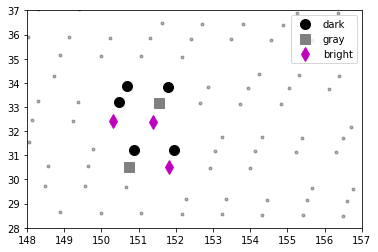

In [5]:
#- Plot those tiles
clf()
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.3, label='_none_')
isdark = tiles['PROGRAM'] == 'DARK'
isgray = tiles['PROGRAM'] == 'GRAY'
isbright = tiles['PROGRAM'] == 'BRIGHT'
plot(tiles['RA'][isdark], tiles['DEC'][isdark], 'o', color='k', ms=10, label='dark')
plot(tiles['RA'][isgray], tiles['DEC'][isgray], 's', color='0.5', ms=10, label='gray')
plot(tiles['RA'][isbright], tiles['DEC'][isbright], 'd', color='m', ms=10, label='bright')
xlim(148, 157); ylim(28, 37)
legend()

## Run survey simulations on the subset of tiles

This will select a test subset of tiles in the NGC and run survey simulations for observations during March 2020.  These steps should take <5 minutes to run.

In [6]:
from desisurvey.progress import Progress
from desisurvey.config import Configuration
Configuration.reset()
config = Configuration(os.path.join(minitestdir, 'desisurvey-config.yaml'))

expfile = os.path.join(surveydir, 'exposures.fits')
if os.path.exists(expfile):
    print('Survey sims already done; skipping')
else:
    survey_logname = os.path.join(surveydir, 'survey.log')
    print('Running survey simulations; logging to {}'.format(survey_logname))
    with open(survey_logname, 'w') as logfile:
        cmd = "surveyinit --config-file ./desisurvey-config.yaml"
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0

        #- Use 0d fiber assignment delay to move on with mini sim quickly
        cmd = "surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --create --fa-delay 0d"
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0

        cmd = "surveysim --config-file ./desisurvey-config.yaml --seed 123"
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0

        plan_cmd = 'surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --fa-delay 0d'
        sim_cmd = 'surveysim --resume --config-file ./desisurvey-config.yaml --seed 123'
        while True:
            lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
            progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
            ndone = np.count_nonzero(progress['status'] == 2)
            print('Starting {} with {}/{} tiles completed {}'.format(lastdate, ndone, len(progress), time.asctime()))
            if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                break
            if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                break

    print('done observing')

Survey sims already done; skipping


### Confirm that we got the expected output files before proceeding

In [7]:
progressfile = os.path.join(surveydir, 'progress.fits')
if not os.path.exists(progressfile):
    print("ERROR: Missing {}".format(progressfile))
    print("Check {} for what might have gone wrong".format(survey_logname))
    print()
    
print('Files in {}:\n'.format(surveydir))
!ls $surveydir

Files in /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey:

ephem_2020-03-15_2020-04-15.fits  plan_2020-03-19.fits	    stats.fits
exposures.fits			  progress.fits		    survey.log
last_date.txt			  progress_2020-03-16.fits  surveyinit.fits
plan.fits			  progress_2020-03-17.fits  weather_123.fits
plan_2020-03-16.fits		  progress_2020-03-19.fits
plan_2020-03-17.fits		  scheduler.fits


### Convert progress.fits -> exposures.fits
progress.fits is one row per tile; convert that into a file with one row per exposure.
Only write the exposure list if all tiles were successfully observed so that file can
be used as a marker of success.

In [8]:
if os.path.exists(expfile):
    print('Reading explist from {}'.format(expfile))
    explist = Table.read(expfile)
else:
    p = Progress(restore='progress.fits')
    explist = p.get_exposures()
    explist = add_calibration_exposures(explist)

    # Sanity check that all tiles in the subset were observed in the exposures list
    if not np.all(np.in1d(tiles['TILEID'], explist['TILEID'])):
        print("ERROR: some tiles weren't observed;\ncheck {} for failures".format(survey_logname) )
        print("Missing TILEIDs:", set(tiles['TILEID']) - set(explist['TILEID']))
    else:
        print("All tiles in the subset were observed at least once")
        explist.write(expfile, overwrite=True)
        print('Wrote {}'.format(expfile))

Reading explist from /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/exposures.fits


## Study which healpixels cover those tiles

In [9]:
isbright = explist['PROGRAM'] == 'BRIGHT'
isgray = explist['PROGRAM'] == 'GRAY'
isdark = explist['PROGRAM'] == 'DARK'

(28, 37)

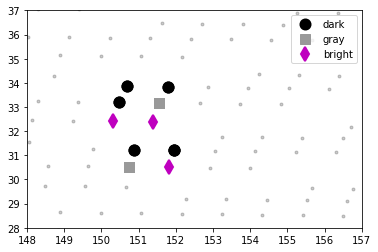

In [10]:
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.2, label='_none_')
plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
plot(explist['RA'][isgray], explist['DEC'][isgray], 's', color='0.6', ms=10, label='gray')
plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', color='m', ms=10, mew=2, label='bright')
legend(loc='upper right')
xlim(148, 157); ylim(28, 37)

In [11]:
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, tiles)
nexp = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))
print('{} tiles covered by {} exposures and {} healpixels'.format(len(tiles), nexp, len(pixels)))

10 tiles covered by 18 exposures and 47 healpixels


In [12]:
pixels

array([5261, 5262, 5263, 5272, 5273, 5274, 5275, 5278, 5281, 5283, 5284,
       5285, 5286, 5287, 5289, 5292, 5293, 5294, 5295, 5296, 5297, 5298,
       5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309,
       5310, 5311, 5346, 5352, 5354, 5636, 5637, 5648, 5649, 5650, 5651,
       5652, 5653, 5654])

(28, 37)

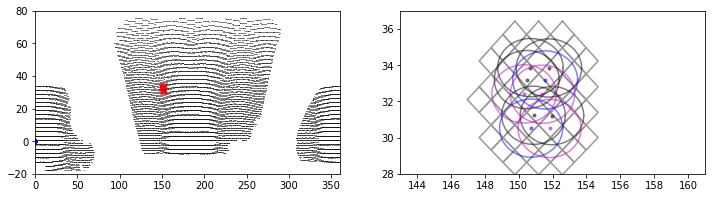

In [13]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plot(x,y, '-', color=color, alpha=0.5)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plot(ra, dec, '-', color='0.6')

figure(figsize=(12,3))
subplot(121)
plot(alltiles['RA'], alltiles['DEC'], 'k,', alpha=0.5)
plot(explist['RA'], explist['DEC'], 'b.', alpha=0.5)
plot(tiles['RA'], tiles['DEC'], 'rx')
xlim(0,360); ylim(-20, 80)

subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = tiles['PROGRAM'] == program
    for t in tiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

xlim(143, 161); ylim(28, 37)

## Run select_mock_targets

This step combines mock catalogs with spectral templates per covered healpixel.
This notebook prints the commands to run in a separate cori login terminal to
get a 15 node interactive job, and then run the `mpi_select_mock_targets` command.
It should take ~15 minutes on 15 nodes.

In [14]:
def is_select_mock_targets_done(targetdir, pixels, verbose=False):
    done = True
    for filetype in ['target', 'truth', 'sky', 'standards-dark', 'standards-bright']:
        filenames = glob.glob(os.path.join(targetdir, '*', '*', '{}*.fits'.format(filetype)))
        if verbose:
            print('{}/{} {} files'.format(len(filenames), len(pixels), filetype))
        if len(filenames) != len(pixels):
            done = False
    return done

# is_select_mock_targets_done(targetdir, pixels)

In [15]:
if is_select_mock_targets_done(targetdir, pixels):
    print("mpi_select_mock_targets already successfully run; skipping")
else:
    logfilename = os.path.join(targetdir, 'select_mock_targets.log')
    tilefile = os.path.join(targetdir, 'test-tiles.fits')
    print('Running mpi_select_mock_targets batch job; this should take ~15 minutes.')
    print("Starting at {}".format(time.asctime()))
    print('Logging to {}'.format(logfilename))

    # configfile = os.path.join(os.getenv('DESITARGET'), 'doc', 'mock_example', 'input.yaml')
    configfile = './select-mock-targets.yaml'
    assert os.path.exists(configfile)
    
    cmd = "srun -A desi -N 15 -n 30 -c 16 -C haswell -t 00:30:00 --qos interactive"
    cmd += " mpi_select_mock_targets --output_dir {targetdir} --config {configfile}"
    cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
    cmd = cmd.format(targetdir=targetdir, tilefile=tilefile, configfile=configfile)
    
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        if err != 0:
            print('mpi_select_mock_targets failed err={}; see {}'.format(err, logfilename))
        else:
            print('done at {}'.format(time.asctime()))

mpi_select_mock_targets already successfully run; skipping


## Check that we got the right number of target output files ##
The number of files of each type should match the number of healpixels

In [16]:
if is_select_mock_targets_done(targetdir, pixels, verbose=True):
    print('Success')
else:
    print('ERROR: missing files')
    print('Check {}'.format(logfilename))

47/47 target files
47/47 truth files
47/47 sky files
47/47 standards-dark files
47/47 standards-bright files
Success


## Merge target, sky, and stdstar catalogs

mpi_select_mock_targets writes targets per healpixel.  This step combines them into full catalogs (but the truth spectra themselves are still kept in individual healpix-organized files, otherwise they would be too big).
It also generates the "Merged Target List" (mtl) that assigns priorities to targets for fiberassignment.
This step is fast so is spawned directly from the notebook without requiring a batch job.

In [17]:
# cmd = "srun -N 4 -n 8 -c 16 -p debug -C haswell -t 00:05:00"
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
err = subprocess.call(cmd.split())
if err != 0:
    print('join_mock_targets failed err={}'.format(err))
else:
    print('success')

join_mock_targets --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --force
success


### Do some sanity checks on the results

In [18]:
targets = fitsio.read(os.path.join(targetdir, 'targets.fits'))
truth   = fitsio.read(os.path.join(targetdir, 'truth.fits'))
mtl     = fitsio.read(os.path.join(targetdir, 'mtl.fits'))
std     = fitsio.read(os.path.join(targetdir, 'standards-dark.fits'))
sky     = fitsio.read(os.path.join(targetdir, 'sky.fits'))

In [19]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


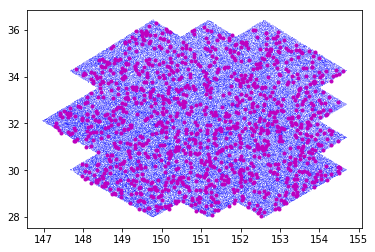

In [20]:
figure(figsize=(6,4))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.')

## Run target selection QA

In [21]:
targetfile = os.path.join(targetdir, 'targets.fits')
targetQAdir = os.path.join(targetdir, 'qa')
targetQAlog = os.path.join(targetQAdir, 'target-qa.log')
os.makedirs(targetQAdir, exist_ok=True)

cmd = 'run_target_qa {} {} --mocks --nside 32'.format(targetfile, targetQAdir)
with open(targetQAlog, 'w') as logfile:
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)

if err != 0:
    print('ERROR running {}'.format(cmd))
    msg = 'see {}'.format(targetQAlog)
    raise RuntimeError(msg)

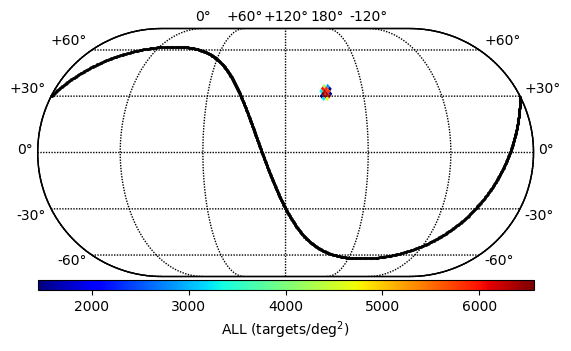

In [22]:
from IPython.display import Image, display
Image(targetQAdir+'/skymap-ALL.png', width=400)

## Run fiberassign

In [23]:
def is_fiberassign_done(fibassigndir, tiles, verbose=False):
    done = True
    for tileid in tiles['TILEID']:
        tilefile = os.path.join(fibassigndir, 'tile_{:05d}.fits'.format(tileid))
        if not os.path.exists(tilefile):
            done = False
            if verbose:
                print('Missing {}'.format(tilefile))

    return done

# is_fiberassign_done(fibassigndir, tiles)

In [24]:
if is_fiberassign_done(fibassigndir, tiles):
    print('fiberassign already done; skipping')
else:
    print('Generating lists of dark and bright tiles')
    #- Write list of tiles to consider
    dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
    bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
    for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
        if program == 'BRIGHT':
            bx.write(str(tileid)+'\n')
        else:
            dx.write(str(tileid)+'\n')

    dx.close()
    bx.close()

    #- Remove any leftover tile files
    for tilefile in glob.glob(fibassigndir+'/tile_*.fits'):
        os.remove(tilefile)

    cmd = "fiberassign "
    cmd += " --mtl {}/mtl.fits".format(targetdir)
    cmd += " --stdstar {}/{{stdfile}}".format(targetdir)
    cmd += " --sky {}/sky.fits".format(targetdir)
    cmd += " --surveytiles {}/{{tilefile}}".format(fibassigndir)
    cmd += " --footprint {}/data/footprint/desi-tiles.fits".format(os.getenv('DESIMODEL'))
    cmd += " --positioners {}/data/focalplane/fiberpos.txt".format(os.getenv('DESIMODEL'))
    cmd += " --fibstatusfile {}/fiberstatus.ecsv".format(minitestdir)
    cmd += " --outdir {}".format(fibassigndir)

    #- Run fiberassign
    logfilename = os.path.join(fibassigndir, 'fiberassign.log')
    print('logging to {}'.format(logfilename))
    with open(logfilename, 'a') as logfile:
        for program in ['dark', 'bright']:
            stdfile = 'standards-{}.fits'.format(program)
            tilefile = '{}-tiles.txt'.format(program)
            cmdx = cmd.format(stdfile=stdfile, tilefile=tilefile)
            print('RUNNING', cmdx)
            err = subprocess.call(cmdx.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('fiberassign failed err={}; see {}'.format(err, logfilename))
        
    #- Run fiberassign
#     logfilename = os.path.join(fibassigndir, 'fiberassign.log')
#     print('Running fiberassign; logging to {}'.format(logfilename))
#     with open(logfilename, 'a') as logfile:
#         cmd = "fiberassign {}/fiberassign-config-dark.txt".format(fibassigndir)
#         err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
#         if err != 0:
#             print('fiberassign failed err={}; see {}'.format(err, logfilename))

#         cmd = "fiberassign {}/fiberassign-config-bright.txt".format(fibassigndir)
#         err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
#         if err != 0:
#             print('fiberassign failed err={}; see {}'.format(err, logfilename))

    if is_fiberassign_done(fibassigndir, tiles, verbose=True):
        print('SUCCESS')
    else:
        print('ERROR: missing fiberassign output files')

fiberassign already done; skipping


#### Run fiberassign QA ####
This will find non-fatal errors with unassigned fibers and too few standards

In [25]:
!qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits

Total SKY fibers 400
Total STDSTAR fibers 95
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01165.fits - ERROR
  5 unassigned fibers
  Petal 6 has 7/10 stdstars
  Petal 7 has 8/10 stdstars
0 stuck fibers
0 broken fibers
Total SKY fibers 400
Total STDSTAR fibers 95
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_06927.fits - ERROR
  6 unassigned fibers
  Petal 2 has 8/10 stdstars
  Petal 5 has 7/10 stdstars
0 stuck fibers
0 broken fibers
Total SKY fibers 400
Total STDSTAR fibers 100
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_11108.fits - ERROR
  6 unassigned fibers
0 stuck fibers
0 broken fibers
Total SKY fibers 400
Total STDSTAR fibers 100
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_16870.fits - ERROR
  10 unassigned fibers
0 stuck fibers
0 broken fibers
Total SKY fibers 400
Total STDSTAR fibers 100
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_18465.fits - ERROR
  9 unassigned fibers
0 stuck fi

## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

Setup the problem and define the commands to run, but then run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

4.4 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes.

In [26]:
def is_newexp_done(explist, simdatadir, verbose=False):
    numnights = len(set(explist['NIGHT']))
    nexp = len(explist)  #- 3 arc/night + 3 flat/night + science
    simspecfiles = glob.glob(simdatadir+'/*/simspec*.fits')
    fibermapfiles = glob.glob(simdatadir+'/*/fibermap*.fits')
    if verbose:
        print('{}/{} simspec files'.format(len(simspecfiles), nexp))
        print('{}/{} fibermap files'.format(len(fibermapfiles), nexp))

    if len(simspecfiles) != nexp:
        return False
    elif len(fibermapfiles) != nexp:
        return False
    else:
        return True

# is_newexp_done(explist, simdatadir, verbose=True)

In [27]:
if is_newexp_done(explist, simdatadir):
    print('newexp already done; skipping')
else:
    logfilename = os.path.join(simdatadir, 'newexp.log')
    tilefile = os.path.join(targetdir, 'test-tiles.fits')

    print('Running wrap-newexp batch job; should take ~5 min')
    print('Starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    nodes = 15

    cmd = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
    cmd += " -C haswell -t 00:15:00 --qos interactive"
    cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
    cmd += " --mockdir {}".format(targetdir)
    cmd += " --obslist {}/exposures.fits".format(surveydir)
    cmd += " --tilefile {}".format(tilefile)
    # print(cmd)
    
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('ERROR {} running wrap-newexp; see {}'.format(err, logfilename))
        else:
            print('done')


newexp already done; skipping


### Confirm that we got the expected newexp output files

In [28]:
if is_newexp_done(explist, simdatadir, verbose=True):
    print('Success')
else:
    print('ERROR: Missing files')

42/42 simspec files
42/42 fibermap files
Success


## Run fastframe to generate noisy uncalibrated spectra

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

6.3 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes

In [29]:
def is_fastframe_done(explist, reduxdir, verbose=False):
    nflat = np.count_nonzero(explist['FLAVOR'] == 'flat')
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    nframe = 30*(nflat + nscience)
    framefiles = glob.glob(reduxdir+'/exposures/*/*/frame*.fits')
    if verbose:
        print('{}/{} frame files'.format(len(framefiles), nframe))
    
    if len(framefiles) != nframe:
        return False
    else:
        return True

# is_fastframe_done(explist, reduxdir, verbose=True)

In [30]:
if is_fastframe_done(explist, reduxdir, verbose=True):
    print('fastframe already done; skipping')
else:
    logfilename = os.path.join(reduxdir, 'exposures', 'fastframe.log')
    os.makedirs(os.path.dirname(logfilename), exist_ok=True)
    print('Running fastframe batch job; should take ~7 min')
    print('Starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    nodes = 15

    cmd = "srun -A desi -N {nodes} -n {nodes} -c 32 -C haswell -t 00:20:00 --qos interactive".format(nodes=nodes)
    cmd += " wrap-fastframe --mpi"
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('ERROR {} running wrap-fastframe; see {}'.format(err, logfilename))
        else:
            print('done at {}'.format(time.asctime()))

if is_fastframe_done(explist, reduxdir, verbose=True):
    print('SUCCESS')
else:
    print('ERROR; see {}'.format(logfilename))

900/900 frame files
fastframe already done; skipping
900/900 frame files
SUCCESS


In [31]:
#- Check individual framefile outputs
ntot = 0
nbad = 0
for night, expid, flavor in explist['NIGHT', 'EXPID', 'FLAVOR']:
    if flavor != 'flat' and flavor != 'science':
        continue

    for channel in ['b', 'r', 'z']:
        for spectrograph in range(10):
            camera = channel + str(spectrograph)
            framefile = desispec.io.findfile('frame', night, expid, camera)
            ntot += 1
            if not os.path.exists(framefile):
                nbad += 1
                print('Missing {} frame {}'.format(flavor, framefile))

if nbad > 0:
    print('Missing {}/{} frame files'.format(nbad, ntot))
else:
    print('All {} science and flat frame files generated'.format(ntot))

All 900 science and flat frame files generated


## Run the spectro pipeline

### First, create the production database.

In [32]:
pipedbfile = desispec.io.get_pipe_database()
if not os.path.exists(pipedbfile):
    cmd = "desi_pipe create --db-sqlite --force"
    cmd += " --data {}".format(os.getenv('DESI_SPECTRO_DATA'))
    cmd += " --redux {}".format(os.getenv('DESI_SPECTRO_REDUX'))
    cmd += " --prod {}".format(os.getenv('SPECPROD'))
    print(cmd)
    err = subprocess.call(cmd.split())
    assert err == 0
    assert os.path.exists(desispec.io.get_pipe_database())
    print('SUCCESS')
else:
    print('spectro pipeline DB file already exists; skipping')

spectro pipeline DB file already exists; skipping


### Sync up with the actual files on disk

We didn't start with raw data files, so we'll skip over extraction and PSF-fitting steps.
`desi_pipe sync` will update the database from what files are actually on disk.

In [33]:
err = subprocess.call('desi_pipe sync'.split())
assert err == 0
output = subprocess.check_output('desi_pipe top --once'.split())
print(output.decode())

----------------+---------+---------+---------+---------+---------+---------+
   Task Type    | waiting | ready   | running | done    | failed  | submit  |
----------------+---------+---------+---------+---------+---------+---------+
preproc         |     1260|        0|        0|        0|        0|        0|
psf             |      360|        0|        0|        0|        0|        0|
psfnight        |      120|        0|        0|        0|        0|        0|
traceshift      |      900|        0|        0|        0|        0|        0|
extract         |        0|        0|        0|      900|        0|        0|
fiberflat       |        0|        0|        0|      360|        0|        0|
fiberflatnight  |        0|        0|        0|      120|        0|        0|
sky             |        0|        0|        0|      540|        0|        0|
starfit         |        0|        0|        0|      180|        0|        0|
fluxcalib       |        0|        0|        0|      540|       

### Run pipeline scripts as a series of interactive jobs

`desi_pipe chain` would be a more convenient way of doing this,
but for the minitest it takes too long to wait for N>>1 jobs in the debug queue.

In [34]:
taskdir = os.path.join(desispec.io.get_pipe_rundir(), 'minitest')
os.makedirs(taskdir, exist_ok=True)

dbpath = desispec.io.get_pipe_database()
db = desispec.pipeline.load_db(dbpath, mode="w")

tasktypes = ['fiberflat', 'fiberflatnight', 'sky', 'starfit', 'fluxcalib', 'cframe', 'spectra', 'redshift']
for tasktype in tasktypes:
    for night in np.unique(explist['NIGHT']):
        db.getready(night)

    taskfile = "{}/{}.tasks".format(taskdir, tasktype)
    cmd = "desi_pipe tasks --tasktype {} --states ready,waiting ".format(tasktype)
    cmd += " > {}".format(taskfile)
    try:
        subprocess.check_call(cmd, shell=True)
    except subprocess.CalledProcessError:
        print('FAILED: {}'.format(cmd))
        break
    
    task_count = db.count_task_states(tasktype)
    if tasktype == 'redshift':
        ranks_per_task = 32
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task // 2  #- two iterations
        nodes = (n-1) // 32 + 1
        runtime = 59    #- minutes
    elif tasktype == 'spectra':
        ranks_per_task = 1
        cores_per_rank = 8
        n = task_count['ready'] * ranks_per_task
        runtime = 20    #- minutes
    else:
        ranks_per_task = 1
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task
        runtime = 15    #- minutes

    nodes = (n*cores_per_rank-1) // 64 + 1

    if n > 0:
        t0 = time.time()
        cmd = 'srun -A desi -t {}:00 -C haswell --qos interactive'.format(runtime)
        cmd += ' -N {nodes} -n {procs} -c {cores} '.format(nodes=nodes, procs=n, cores=cores_per_rank)
        cmd += ' desi_pipe_exec_mpi --tasktype {} --taskfile {}'.format(tasktype, taskfile)
        logfilename = '{}/{}.log'.format(taskdir, tasktype)
        print('Running {} {} tasks'.format(n, tasktype))
        print('Logging to {}'.format(logfilename))
        print(cmd)
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('    ERROR {} for tasktype {}'.format(err, tasktype))
                print('    See {}'.format(logfilename))
            else:
                dt = time.time() - t0
                print('  DONE at {}'.format(time.asctime()))
                print('  {} took {:.1f} min'.format(tasktype, dt/60))
    elif task_count['waiting'] == 0 and task_count['done'] > 0:
        print('All {} tasks already run'.format(tasktype))
    else:
        print('No {} tasks ready to run; skipping'.format(tasktype))

for night in np.unique(explist['NIGHT']):
    db.getready(night)

print(subprocess.check_output('desi_pipe top --once'.split()).decode())

All fiberflat tasks already run
All fiberflatnight tasks already run
All sky tasks already run
All starfit tasks already run
All fluxcalib tasks already run
All cframe tasks already run
All spectra tasks already run
All redshift tasks already run
----------------+---------+---------+---------+---------+---------+---------+
   Task Type    | waiting | ready   | running | done    | failed  | submit  |
----------------+---------+---------+---------+---------+---------+---------+
preproc         |     1260|        0|        0|        0|        0|        0|
psf             |      360|        0|        0|        0|        0|        0|
psfnight        |      120|        0|        0|        0|        0|        0|
traceshift      |      900|        0|        0|        0|        0|        0|
extract         |        0|        0|        0|      900|        0|        0|
fiberflat       |        0|        0|        0|      360|        0|        0|
fiberflatnight  |        0|        0|        0|    

## Study job runtimes

Some pipeline steps are taking longer than expected.
It appears to be due to throttling while updating the sqlite database;
the results are much better when using the postgres backend.  This plot
shows the endtime vs. starttime of each fiberflat task.

In [35]:
def parse_timestamp(line):
    line = line.strip()
    h,m,s = map(int, line[-13:-13+8].split(':'))
    return h*3600 + m*60 + s

fflogs = glob.glob('{}/logs/night/*/fiberflat_*.log'.format(desispec.io.get_pipe_rundir()))
assert(len(fflogs) > 0)
xstart = list()
xend = list()
for filename in fflogs:
    start = end = 0
    with open(filename) as fx:
        for line in fx:
            if line.count(' starting at ') > 0:
                start = parse_timestamp(line)
            elif line.count(' done at ') > 0:
                end = parse_timestamp(line)
                break
    xstart.append(start)
    xend.append(end)

Text(0.5,0,'time')

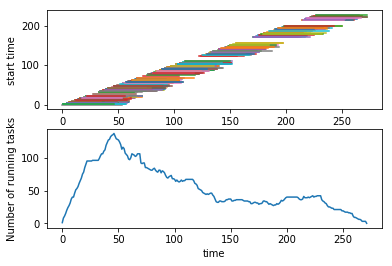

In [36]:
xstart = np.asarray(xstart)
xend = np.asarray(xend)
t0 = np.min(xstart)
xstart -= t0
xend -= t0

subplot(211)
for a, b in zip(xstart, xend):
    plot([a,b], [a,a])

xlabel('time')
ylabel('start time')

subplot(212)
tx = np.arange(0, np.max(xend))
ntasks = list()
for t in tx:
    n = np.count_nonzero((xstart <= t) & (t+1 < xend))
    ntasks.append(n)

plot(tx, ntasks)
ylabel('Number of running tasks')
xlabel('time')

## Job monitoring

The below isn't used by the current notebook that directly spawns srun, but it may become useful again
if using `desi_pipe chain`, so leaving in here for now.

In [37]:
#- Monitor queue until those jobs are done
def count_jobs(jobname):
    cmd = 'squeue -u {}'.format(os.getenv('USER'))
    proc = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = proc.communicate()
    njob = 0
    for line in stdout.split(b'\n'):
        if line.find(jobname) > 0:
            njob += 1

    return njob

print('To check details, run this on cori.nersc.gov:')
print('    squeue -u {}'.format(os.getenv('USER')))
n = count_jobs(b'debug fiberfla')
while n > 0:
    nsleep = n*2
    print('{} jobs still queued or running; sleeping {} minutes'.format(n, nsleep))
    time.sleep(nsleep*60)
    n = count_jobs(b'debug fiberfla')
print('All jobs finished')

To check details, run this on cori.nersc.gov:
    squeue -u sjbailey
All jobs finished


### Check that we got expected outputs

In [38]:
def is_cframe_done(explist, reduxdir, verbose=False):
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    ncframe = 30*nscience
    cframefiles = glob.glob(reduxdir+'/exposures/*/*/cframe*.fits')
    if verbose:
        print('{}/{} cframe files'.format(len(cframefiles), ncframe))
    
    if len(cframefiles) != ncframe:
        return False
    else:
        return True

is_cframe_done(explist, reduxdir, verbose=True)

540/540 cframe files


True

In [39]:
if not is_cframe_done(explist, reduxdir, verbose=True):
    print('ERROR: missing cframe files')
else:
    print('All cframe files successfully generated')

540/540 cframe files
All cframe files successfully generated


In [40]:
def is_regrouping_done(pixels, reduxdir):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra-*.fits')
    #- some pixels might not be covered by real data, but most should be
    if len(specfiles) < len(pixels) - 5:
        return False
    else:
        return True

is_regrouping_done(pixels, reduxdir)

True

## Did all pixels make it from sims -> output spectra?

It looks like tiles2pix was conservative and included some edge pixels that weren't
really necessary.

Missing spectra-64-5636.fits


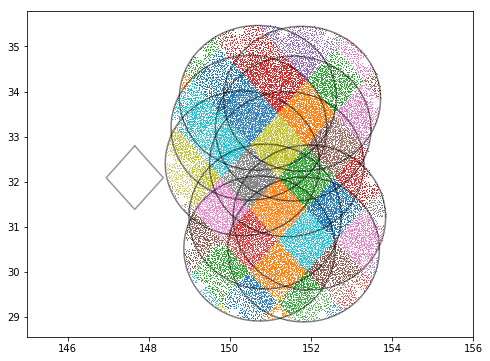

In [41]:
nside=64
misspix = list()
figure(figsize=(8,6))
for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))
    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['RA_TARGET'], fibermap['DEC_TARGET'], ',', alpha=0.5)

plot_healpix(nside, misspix)
for t in tiles:
    plot_tile(t['RA'], t['DEC'])

tmp = xlim(145, 156)

In [42]:
def is_redrock_done(reduxdir, verbose=False):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra*.fits')
    zbestfiles = glob.glob(reduxdir+'/spectra-*/*/*/zbest*.fits')
    if verbose:
        print('{}/{} zbest files'.format(len(zbestfiles), len(specfiles)))
    if len(zbestfiles) != len(specfiles):
        return False
    else:
        return True

is_redrock_done(reduxdir, verbose=True)

46/46 zbest files


True

### Count number of spectra and targets per healpix

In [43]:
specdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'], 'spectra-64')
specfiles = list()
for specfile in sorted(list(desitarget.io.iter_files(specdir, 'spectra'))):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm) * 3
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )

In [44]:
print('==================== ===== ========')
print('specfile             nspec ntargets')
print('==================== ===== ========')
for ntarg, nspec, specfile in sorted(specfiles):
    print("{0:20s} {1:5d} {2:8d}".format(os.path.basename(specfile), nspec, ntarg))
print('==================== ===== ========')

==================== ===== ========
specfile             nspec ntargets
==================== ===== ========
spectra-64-5289.fits    72        6
spectra-64-5301.fits   156       13
spectra-64-5281.fits   240       20
spectra-64-5294.fits   240       39
spectra-64-5650.fits   480       39
spectra-64-5261.fits   282       47
spectra-64-5354.fits   612       51
spectra-64-5273.fits   336       56
spectra-64-5654.fits   720       60
spectra-64-5283.fits   936       78
spectra-64-5346.fits  1008       84
spectra-64-5262.fits   858       94
spectra-64-5653.fits  1992      139
spectra-64-5278.fits  2490      139
spectra-64-5272.fits  1056      176
spectra-64-5651.fits  2160      177
spectra-64-5352.fits  2568      214
spectra-64-5637.fits  2406      288
spectra-64-5292.fits  7194      602
spectra-64-5300.fits  9408      727
spectra-64-5284.fits  7842      751
spectra-64-5652.fits 12060      820
spectra-64-5303.fits  9690      827
spectra-64-5311.fits 11988      835
spectra-64-5263.fits  8250  

## Create zcatalog

This is just a merging of the individual zbest files

In [45]:
zcatfile = desispec.io.findfile('zcatalog')
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {zcatfile} --match {targetdir}/targets.fits'.format(
        reduxdir=reduxdir, zcatfile=zcatfile, targetdir=targetdir)
print(cmd)
!$cmd

desi_zcatalog -i /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/spectra-64 -o /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/zcatalog-mini.fits --match /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/targets.fits
INFO:desi_zcatalog:105:<module>: matching /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/targets.fits
INFO:desi_zcatalog:111:<module>: wrote /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/zcatalog-mini.fits


## Redshift QA

This section does some "by-hand" redshift QA, bypassing the standard spectro pipeline QA (see below).

In [46]:
from desisim.spec_qa import redshifts as dsq_z

In [47]:
truth = Table.read(os.path.join(targetdir, 'truth.fits'))
zcat = Table.read(zcatfile)

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

In [48]:
import astropy.table
del zcat.meta['EXTNAME']
del truth.meta['EXTNAME']
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [49]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')
print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  3398
LRG  5868
ELG  16252
STAR 3084
BGS  12143


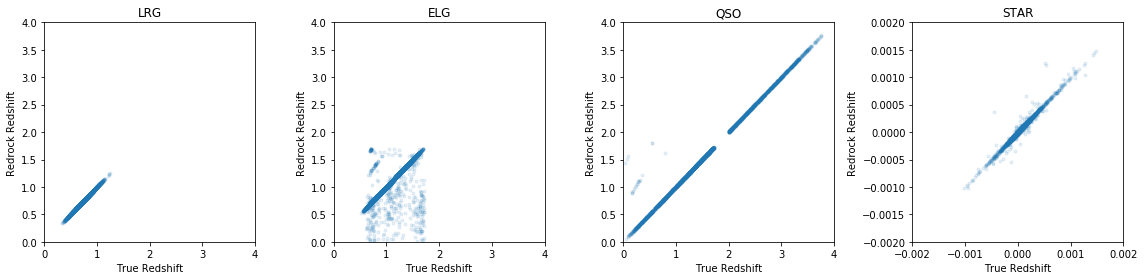

In [50]:
def plotz(ztruth, label, zmin=0.0, zmax=1.5, ylabel_=None):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.1)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)
    xlabel('True Redshift')
    ylabel('Redrock Redshift')

figure(figsize=(16,4))
subplot(141); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(142); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(143); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(144); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)
tight_layout()

In [62]:
# Merge the truth and zcat tables
# match_truth_z fails on the repeated TARGETID=-1 of unassigned fibers, so filter those out
assigned = zcat['TARGETID'] >= 0
dsq_z.match_truth_z(truth, zcat[assigned], mini_read=True)

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [63]:
print('          ntarg   good  fail  miss  lost')
for objtype in set(truth['TEMPLATETYPE']):
    #isx = (truth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost, nx = dsq_z.zstats(truth, objtype=objtype)
    #nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

          ntarg   good  fail  miss  lost
WD           84  100.0   0.0   0.0   0.0
BGS       13439   98.9   0.1   0.4   0.6
LRG        5868  100.0   0.0   0.0   0.0
ELG       16687   92.4   1.0   1.9   4.6
QSO_T      2570   97.1   1.0   0.5   1.4
QSO_L       920  100.0   0.0   0.0   0.0
STAR       3084   82.8   2.4   0.5  14.3

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift ZWARN!=0 (missed opportunities)
lost = wrong redshift ZWARN!=0 (wrong but at least we know it)


## Spectral Classification Confusion Matrix

To be replaced with `desisim.spec_qa.redshifts.spectype_confusion` in a post-18.3 version.

In [134]:
#- Confusion matrix
specmix = dict()
spectypes = sorted(set(ztruth['TRUESPECTYPE']))

for s1 in spectypes:
    specmix[s1] = dict()
    for s2 in spectypes:
        n = np.count_nonzero((ztruth['TRUESPECTYPE']==s1) & (ztruth['SPECTYPE'] == s2))
        specmix[s1][s2] = n

 34261     2     0     0
    16  3382     0     0
   513     0  2571     0
     0     0    84     0


In [135]:
#- Print header line
print('            Redrock')
print('Truth     ', end='')
for s1 in spectypes:
    print('{:>8s}'.format(s1), end='')
print()
    
for s1 in spectypes:
    print('{:8s}  '.format(s1), end='')
    for s2 in spectypes:
        print('{:8d}'.format(specmix[s1][s2]), end='')
    print()

            Redrock
Truth       GALAXY     QSO    STAR      WD
GALAXY       34261       2       0       0
QSO             16    3382       0       0
STAR           513       0    2571       0
WD               0       0      84       0


## Study target coverage

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'NUMEXP')

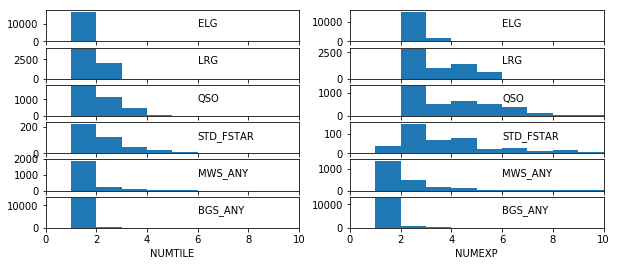

In [136]:
from desitarget.targetmask import desi_mask
from collections import Counter

figure(figsize=(10,4))
for i, targtype in enumerate(['ELG', 'LRG', 'QSO', 'STD_FSTAR', 'MWS_ANY', 'BGS_ANY']):
    ii = (zcat['DESI_TARGET'] & desi_mask[targtype]) != 0
    subplot(6,2,1+2*i)
    n = hist(zcat['NUMTILE'][ii], 10, (0,10))[0]
    text(6, np.max(n)/2, targtype)
    xlim(0,10)
    if i<5:
        xticks([0,2,4,6,8,10], ['']*6)
    subplot(6,2,2+2*i)
    n = hist(zcat['NUMEXP'][ii], 10, (0,10))[0]
    text(6, np.max(n)/2, targtype)
    xlim(0,10)
    if i<5:
        xticks([0,2,4,6,8,10], ['']*6)

subplot(6,2,11); xlabel('NUMTILE')
subplot(6,2,12); xlabel('NUMEXP')


## Load the Spectro Catalog Database

Start by configuring the database, then load exposures, truth, targets, fiberassign, and the redshift catalog.

In [137]:
from argparse import Namespace
from desispec.database.datachallenge import (setup_db, dbSession, load_file,
                                             ObsList, Target, Truth, ZCat, FiberAssign,
                                             load_fiberassign, load_zcat)
options = Namespace(clobber=True, dbfile=os.path.join(basedir, 'minitest.db'), hostname=None, maxrows=0,
                    chunksize=50000, schema=None, username=None, verbose=False, datapath=basedir)
# We'll be using a SQLite database, ignore the return value of setup_db
postgresql = setup_db(options)
load_file(expfile, ObsList, hdu='EXPOSURES', expand={'PASS': 'passnum'})
load_file(os.path.join(targetdir, 'truth.fits'), Truth, hdu='TRUTH')
load_file(os.path.join(targetdir, 'targets.fits'), Target, hdu="TARGETS")
load_fiberassign(fibassigndir)
load_zcat(reduxdir)


INFO:datachallenge.py:613:setup_db: Begin creating tables.
INFO:datachallenge.py:617:setup_db: Finished creating tables.
INFO:datachallenge.py:313:load_file: Read data from /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/exposures.fits.
INFO:datachallenge.py:325:load_file: Integrity check complete on obslist.
INFO:datachallenge.py:328:load_file: Initial column conversion complete on obslist.
INFO:datachallenge.py:350:load_file: Column expansion complete on obslist.
INFO:datachallenge.py:356:load_file: Column conversion complete on obslist.
INFO:datachallenge.py:363:load_file: Converted columns into rows on obslist.
INFO:datachallenge.py:370:load_file: Inserted 42 rows in obslist.
INFO:datachallenge.py:313:load_file: Read data from /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/truth.fits.
INFO:datachallenge.py:325:load_file: Integrity check complete on truth.
INFO:datachallenge.py:328:load_file: Initial column conversion complete on truth.
INFO:datachallenge.py:350:load_f

### Demonstrate the SQLAlchemy objects


In [138]:
q = dbSession.query(Truth, ZCat).filter(Truth.targetid == ZCat.targetid).all()

In [139]:
q[0][0].truez, q[0][1].z

(0.5218037366867065, 0.5220061433650929)

# QA

## Initialize QA output directory

In [140]:
# New dir to define and make
qaprod_dir = desispec.io.qaprod_root()
os.makedirs(qaprod_dir, exist_ok=True)
qaprod_dir

'/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA'

In [141]:
#- Helper function for timing QA commands
def time_command(cmd, logfile):
    t0 = time.time()
    print('{} RUNNING {}'.format(time.asctime(), cmd))
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    assert err == 0
    dt = time.time() - t0
    if dt < 60:
        print('"{}" took {:.1f} seconds'.format(cmd, time.time()-t0))
    else:
        print('"{}" took {:.1f} minutes'.format(cmd, dt/60))
    return err

### QA with the Truth

The following QA uses the input truth table.  

In [142]:
qat_logname = os.path.join(qaprod_dir, 'qa_truth.log')

In [143]:
qa0_time = time.time()
with open(qat_logname, 'w') as logfile:

    if len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10:
        print("S/N figures already exist")
    else:
        # S/N (~7min)
        cmd = "desi_qa_s2n --qaprod_dir={:s}".format(qaprod_dir)
        time_command(cmd, logfile)
    
    # zfind (~2min)
    if (len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6) and os.path.exists(qaprod_dir+'/QA_dzsumm.png'):
        print("zfind figures already exist")
    else:
        cmd = "desi_qa_zfind --yaml_file={:s}/dzsumm_stats.yaml --qaprod_dir={:s}".format(qaprod_dir, qaprod_dir) 
        time_command(cmd, logfile)
    
# Time me
print("Done with QA with truth at {}".format(time.asctime()))
qa_truth_time = time.time() - qa0_time
print("That took {:.1f} minutes".format(qa_truth_time/60))

Thu May 10 12:38:35 2018 RUNNING desi_qa_s2n --qaprod_dir=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA
"desi_qa_s2n --qaprod_dir=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA" took 9.4 minutes
Thu May 10 12:47:57 2018 RUNNING desi_qa_zfind --yaml_file=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA/dzsumm_stats.yaml --qaprod_dir=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA
"desi_qa_zfind --yaml_file=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA/dzsumm_stats.yaml --qaprod_dir=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA" took 35.8 seconds
Done with QA with truth at Thu May 10 12:48:33 2018
That took 10.0 minutes


### Check

In [144]:
assert len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10
assert len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6
assert os.path.exists(qaprod_dir+'/QA_dzsumm.png')

### Show

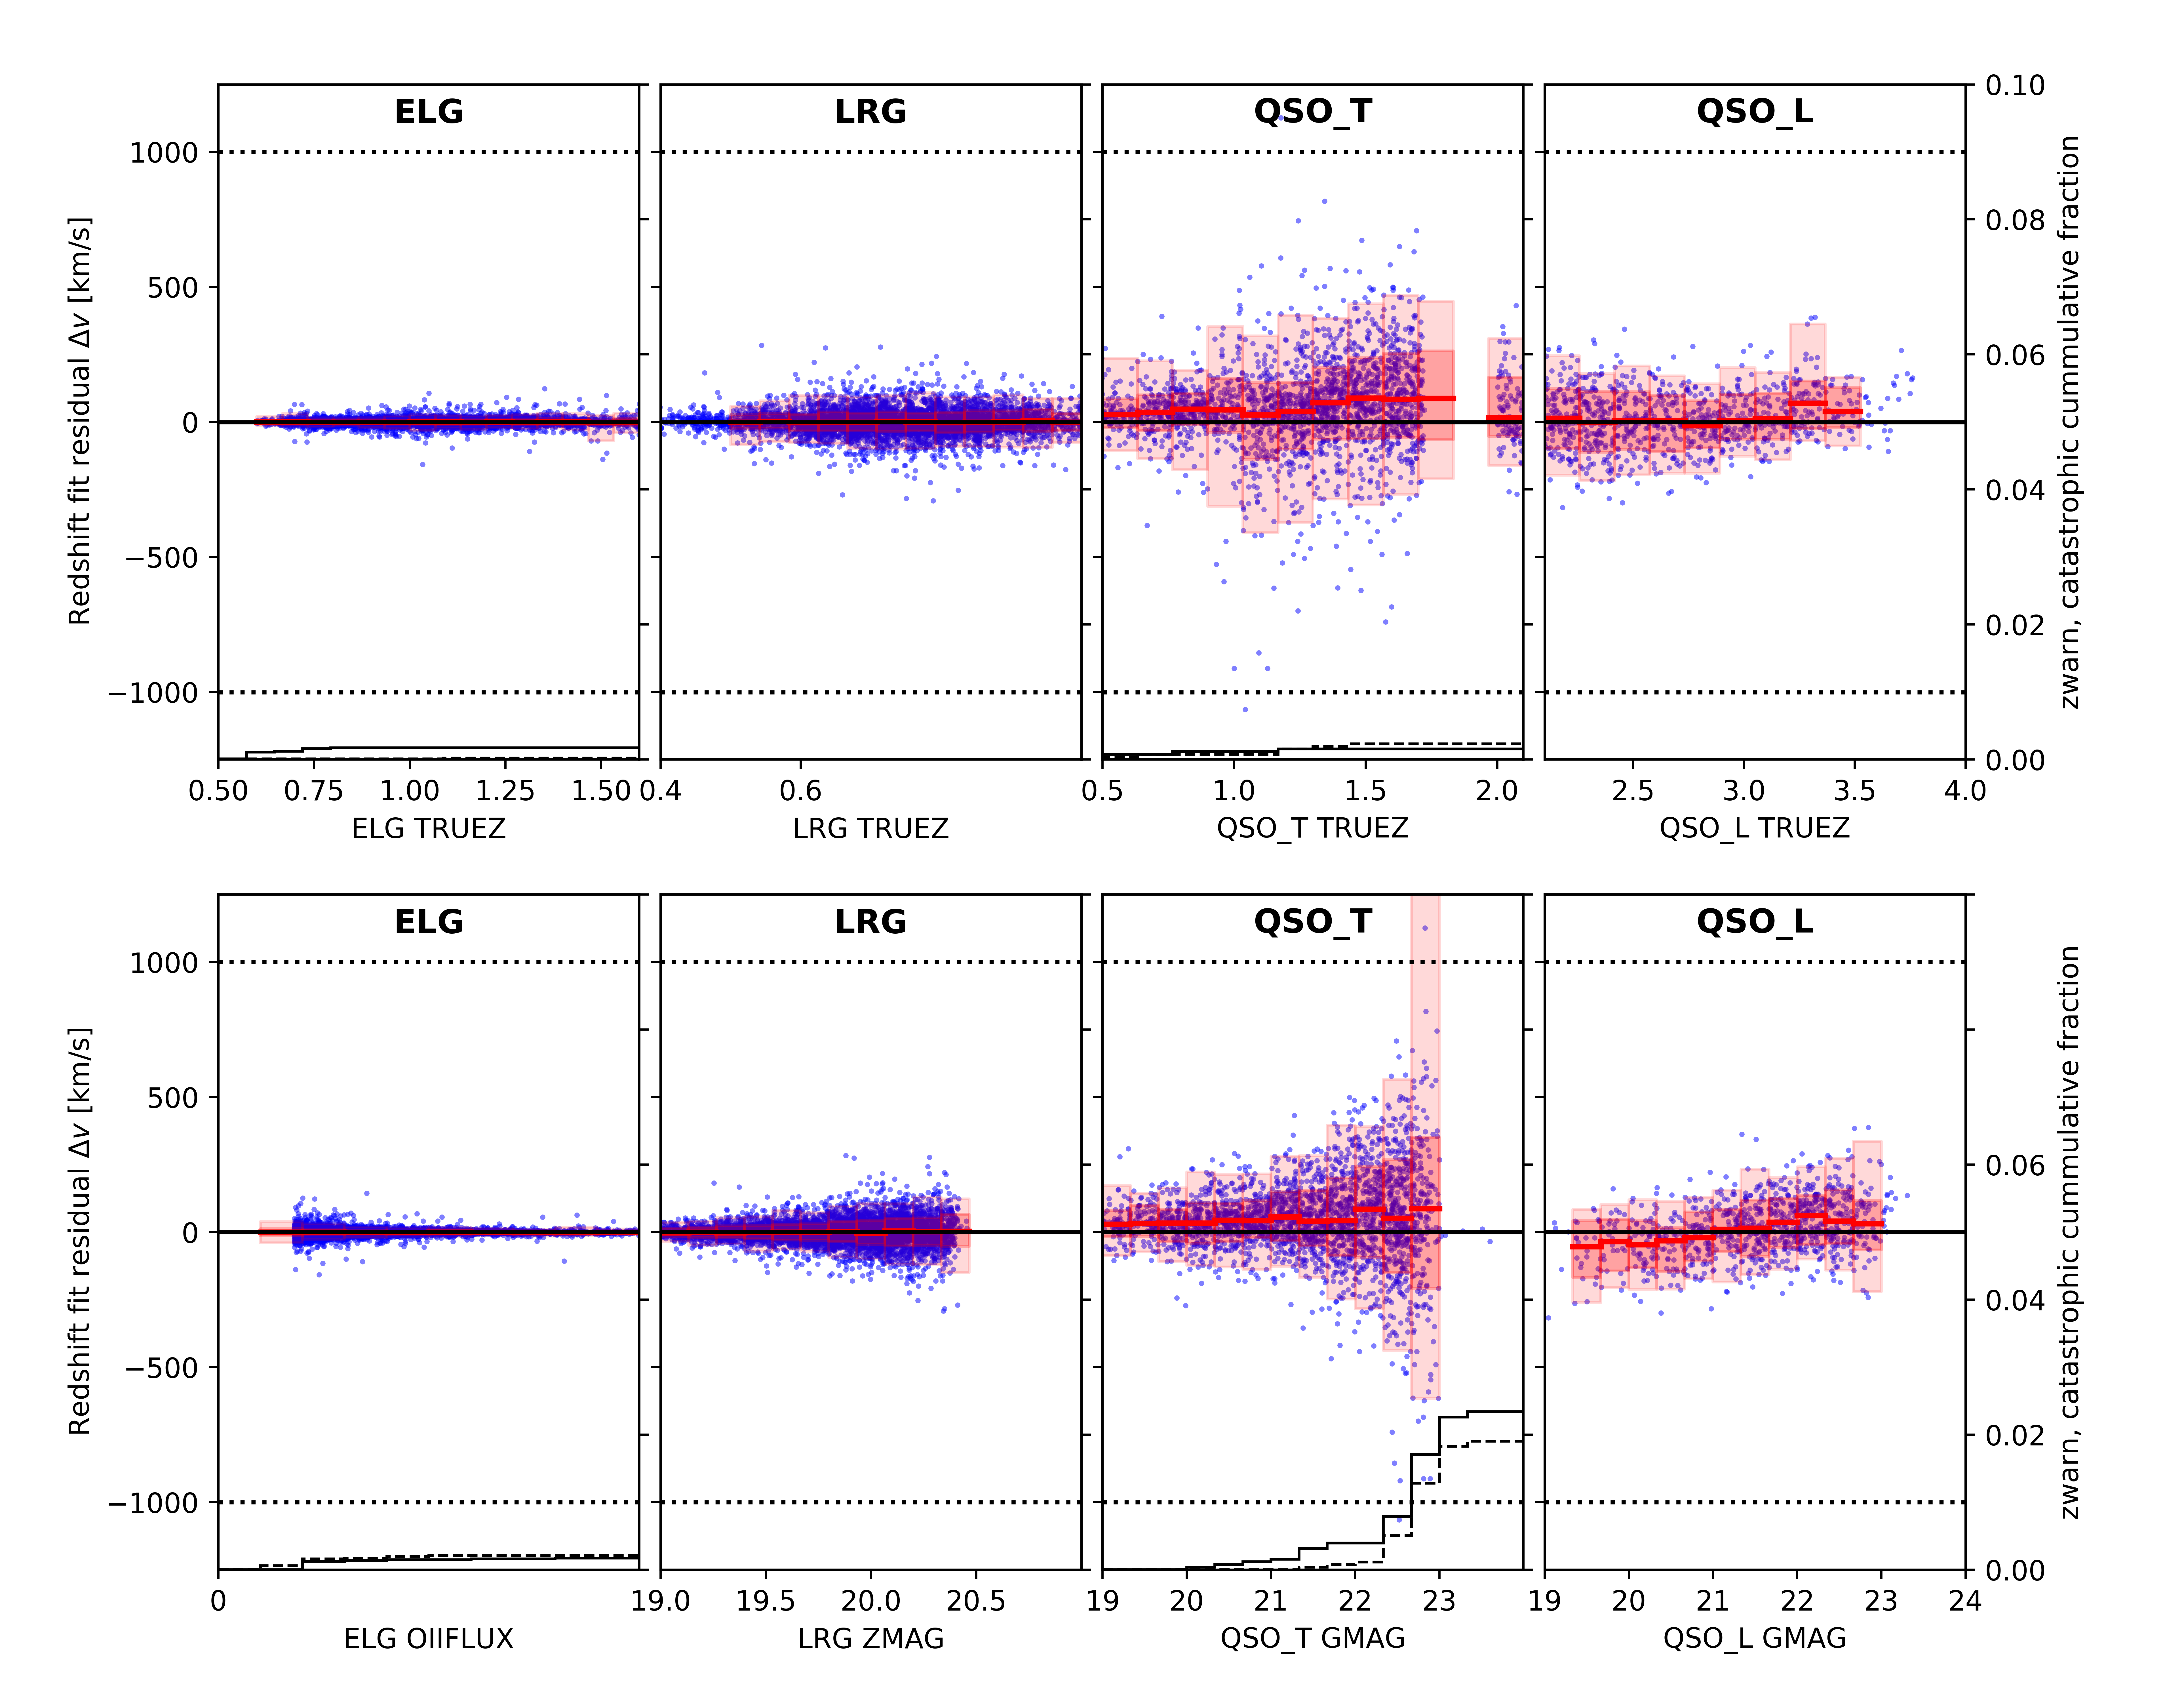

In [145]:
from IPython.display import Image, display
Image(filename=qaprod_dir+'/QA_dzsumm.png') 

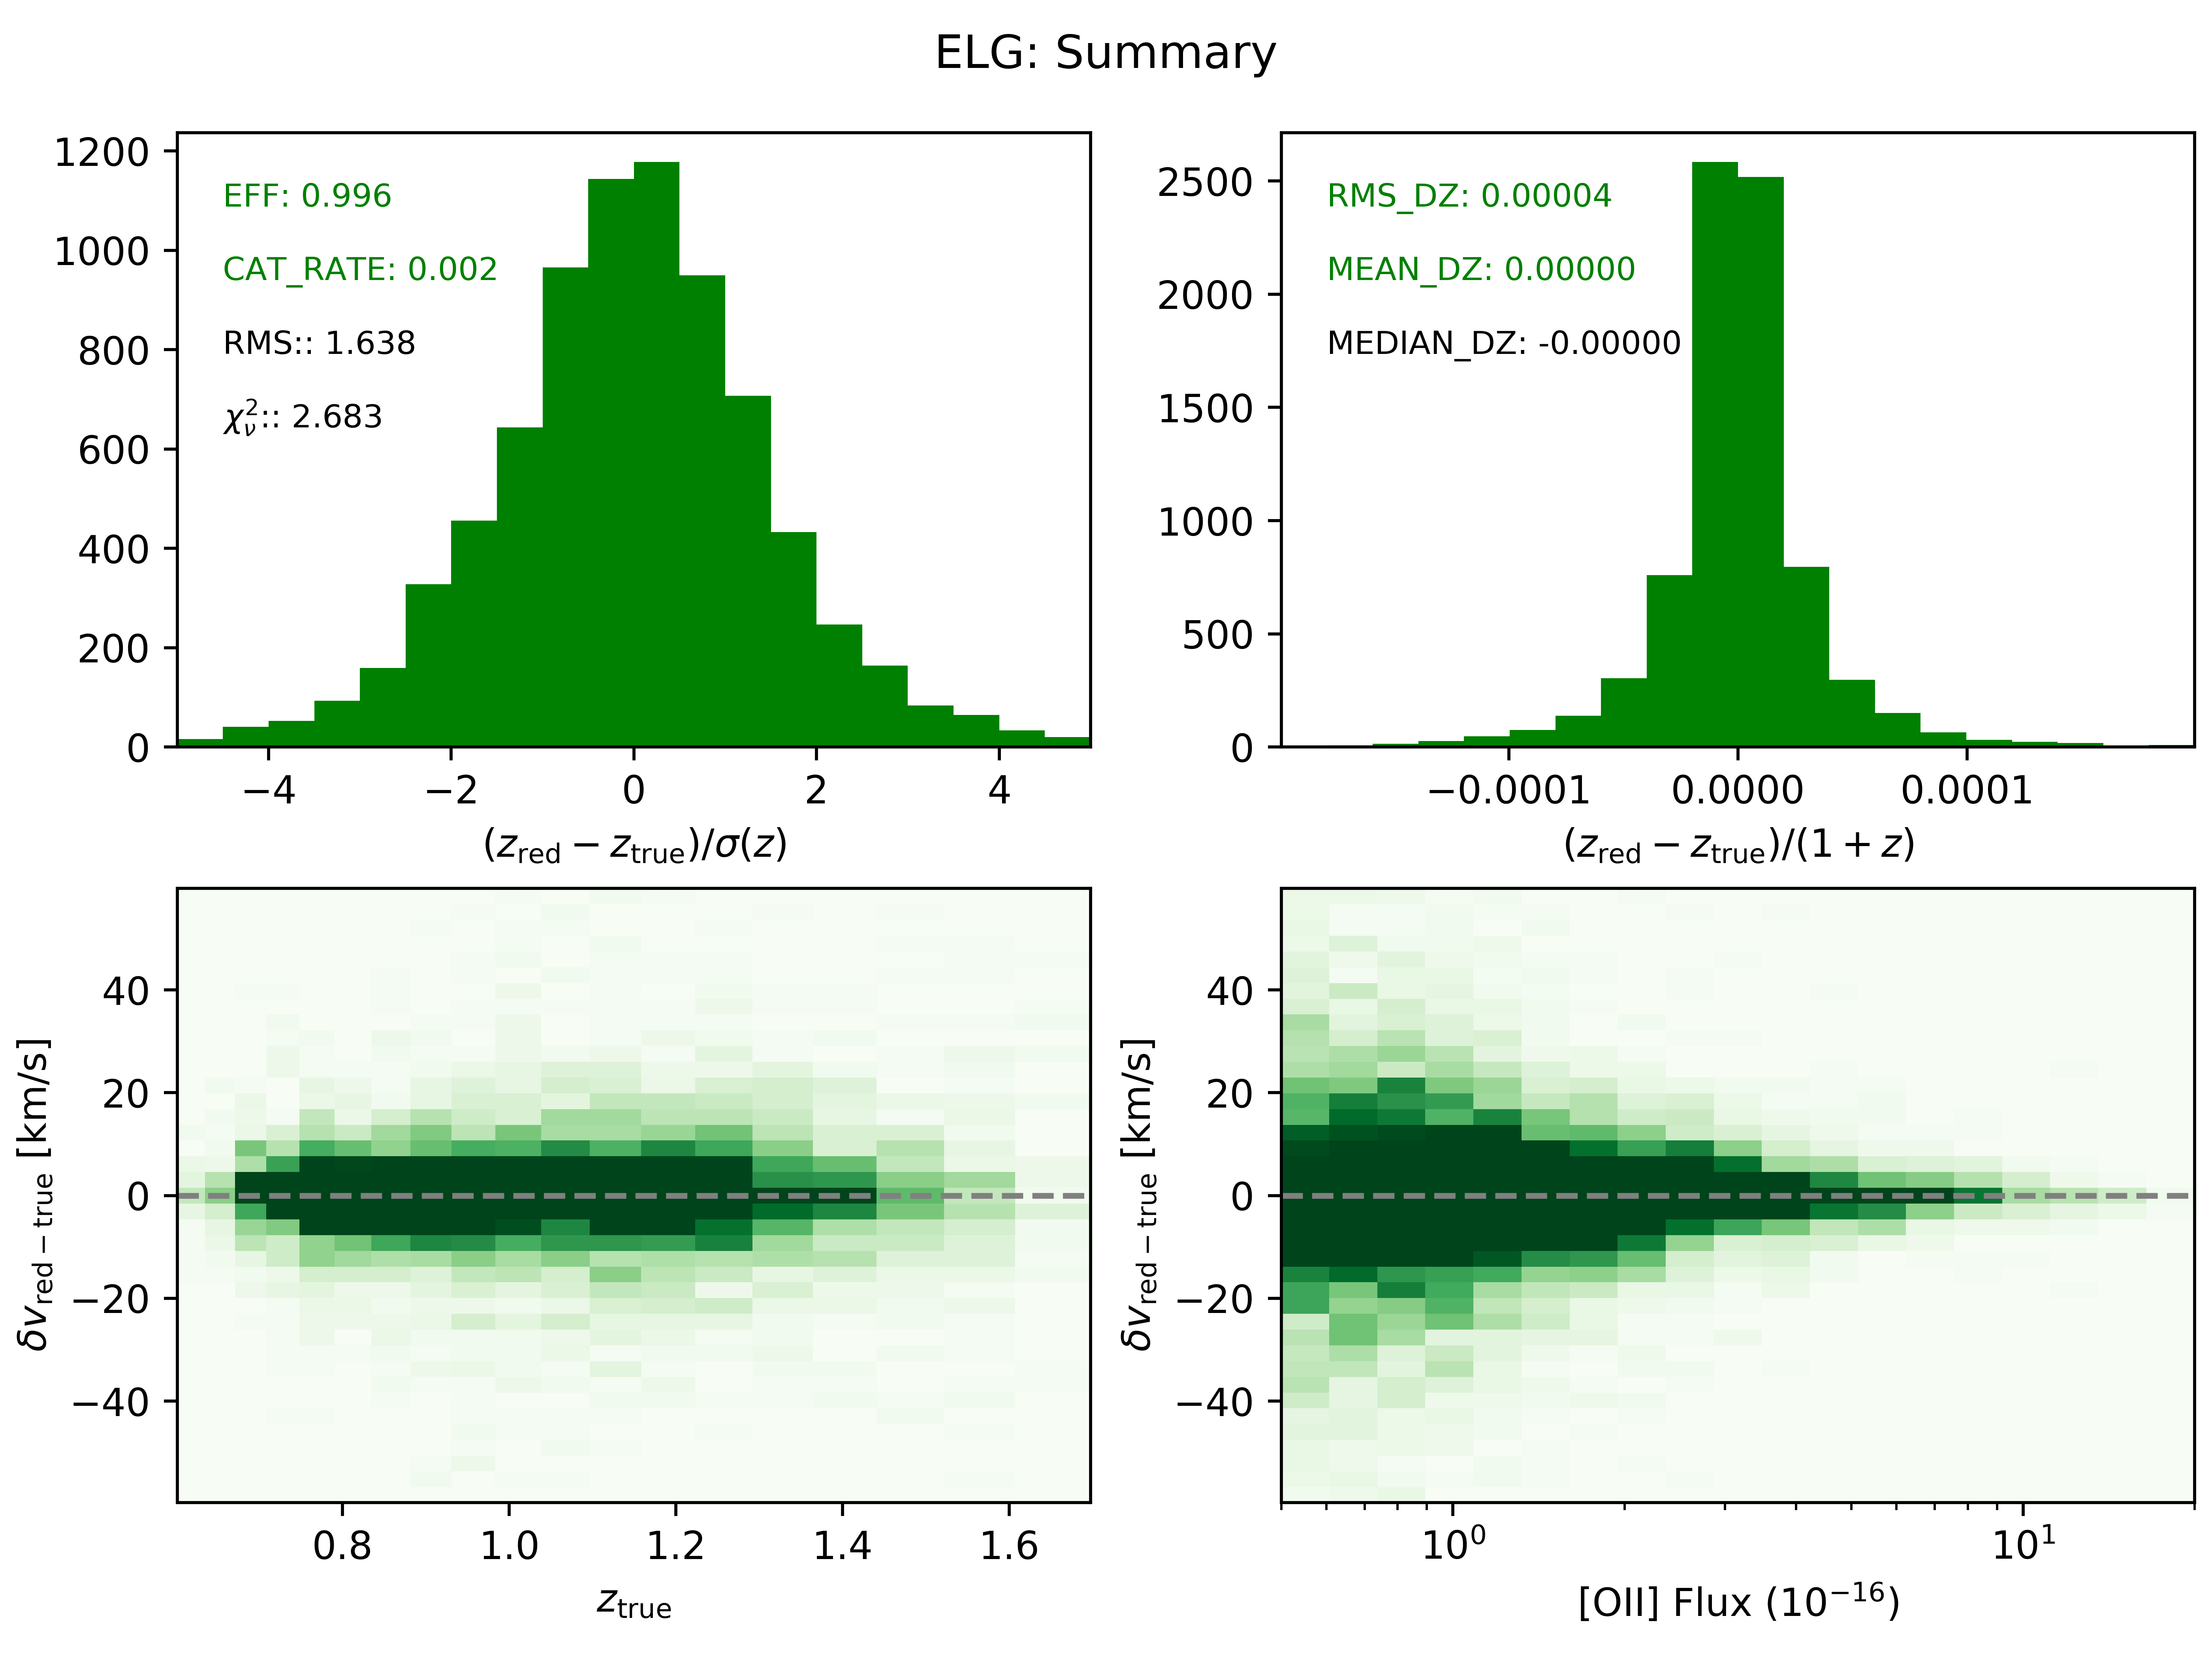

In [146]:
Image(filename=qaprod_dir+'/QA_zfind_ELG.png', width=500)

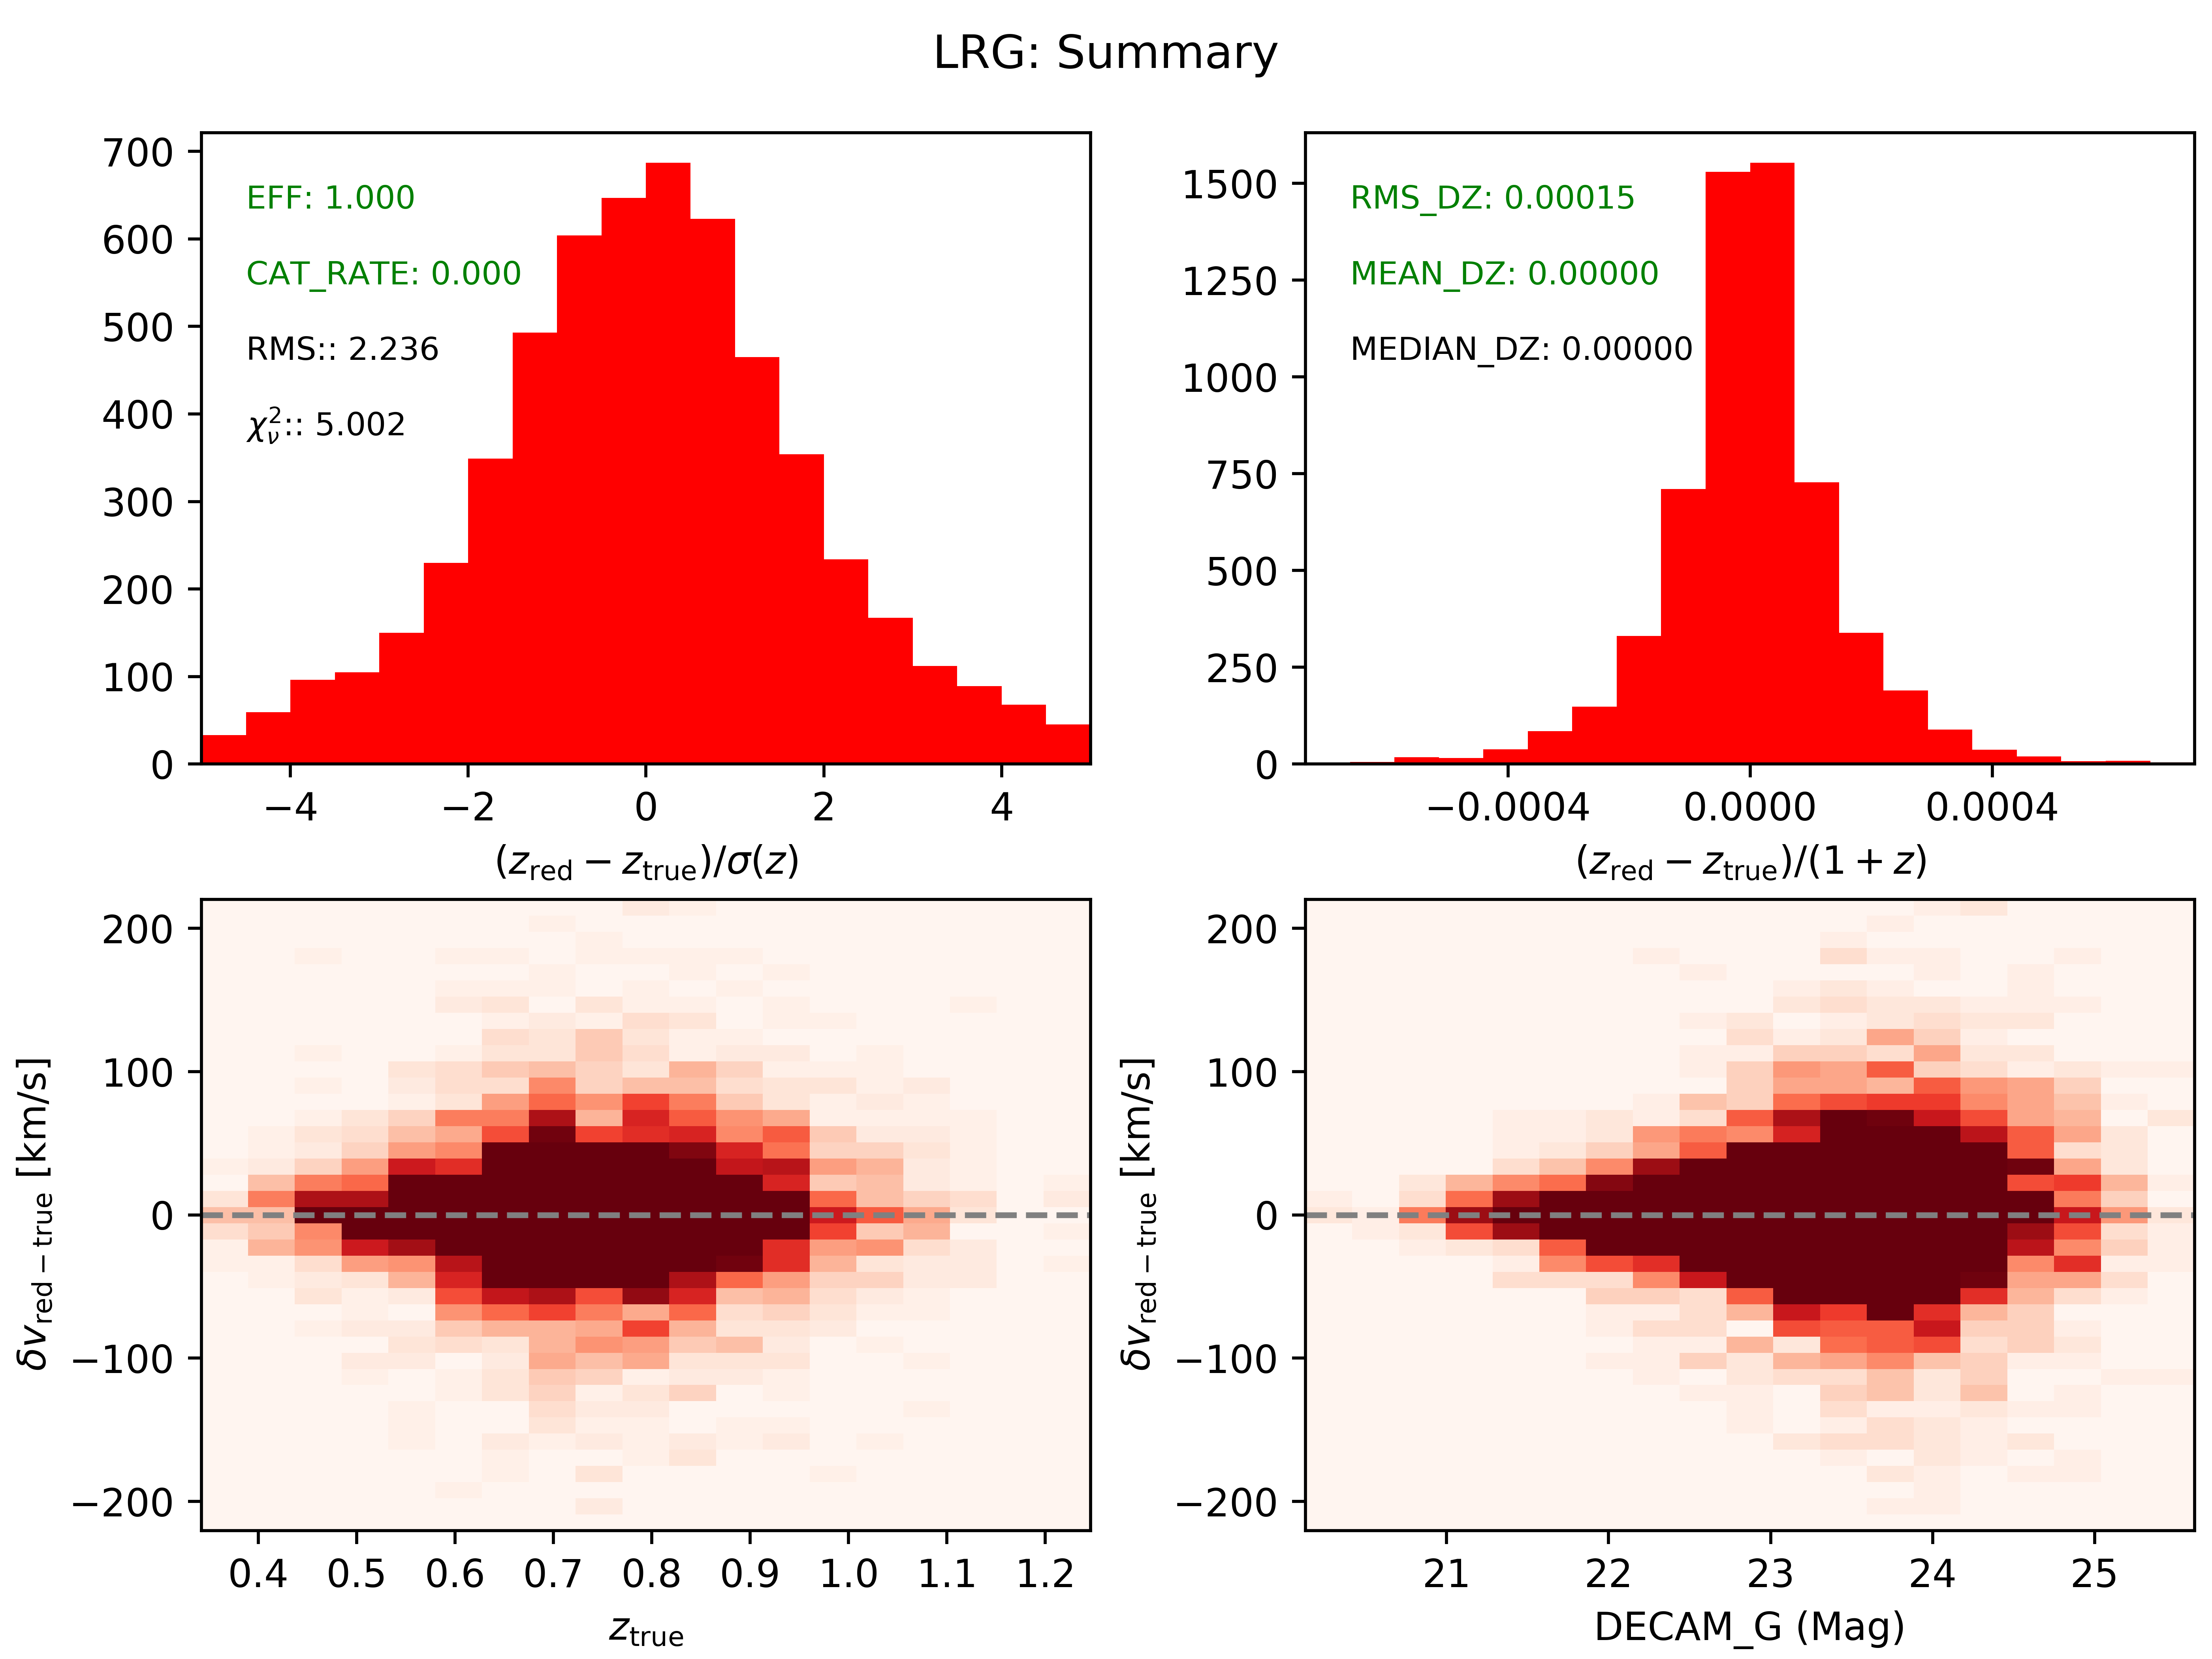

In [147]:
Image(filename=qaprod_dir+'/QA_zfind_LRG.png', width=500)

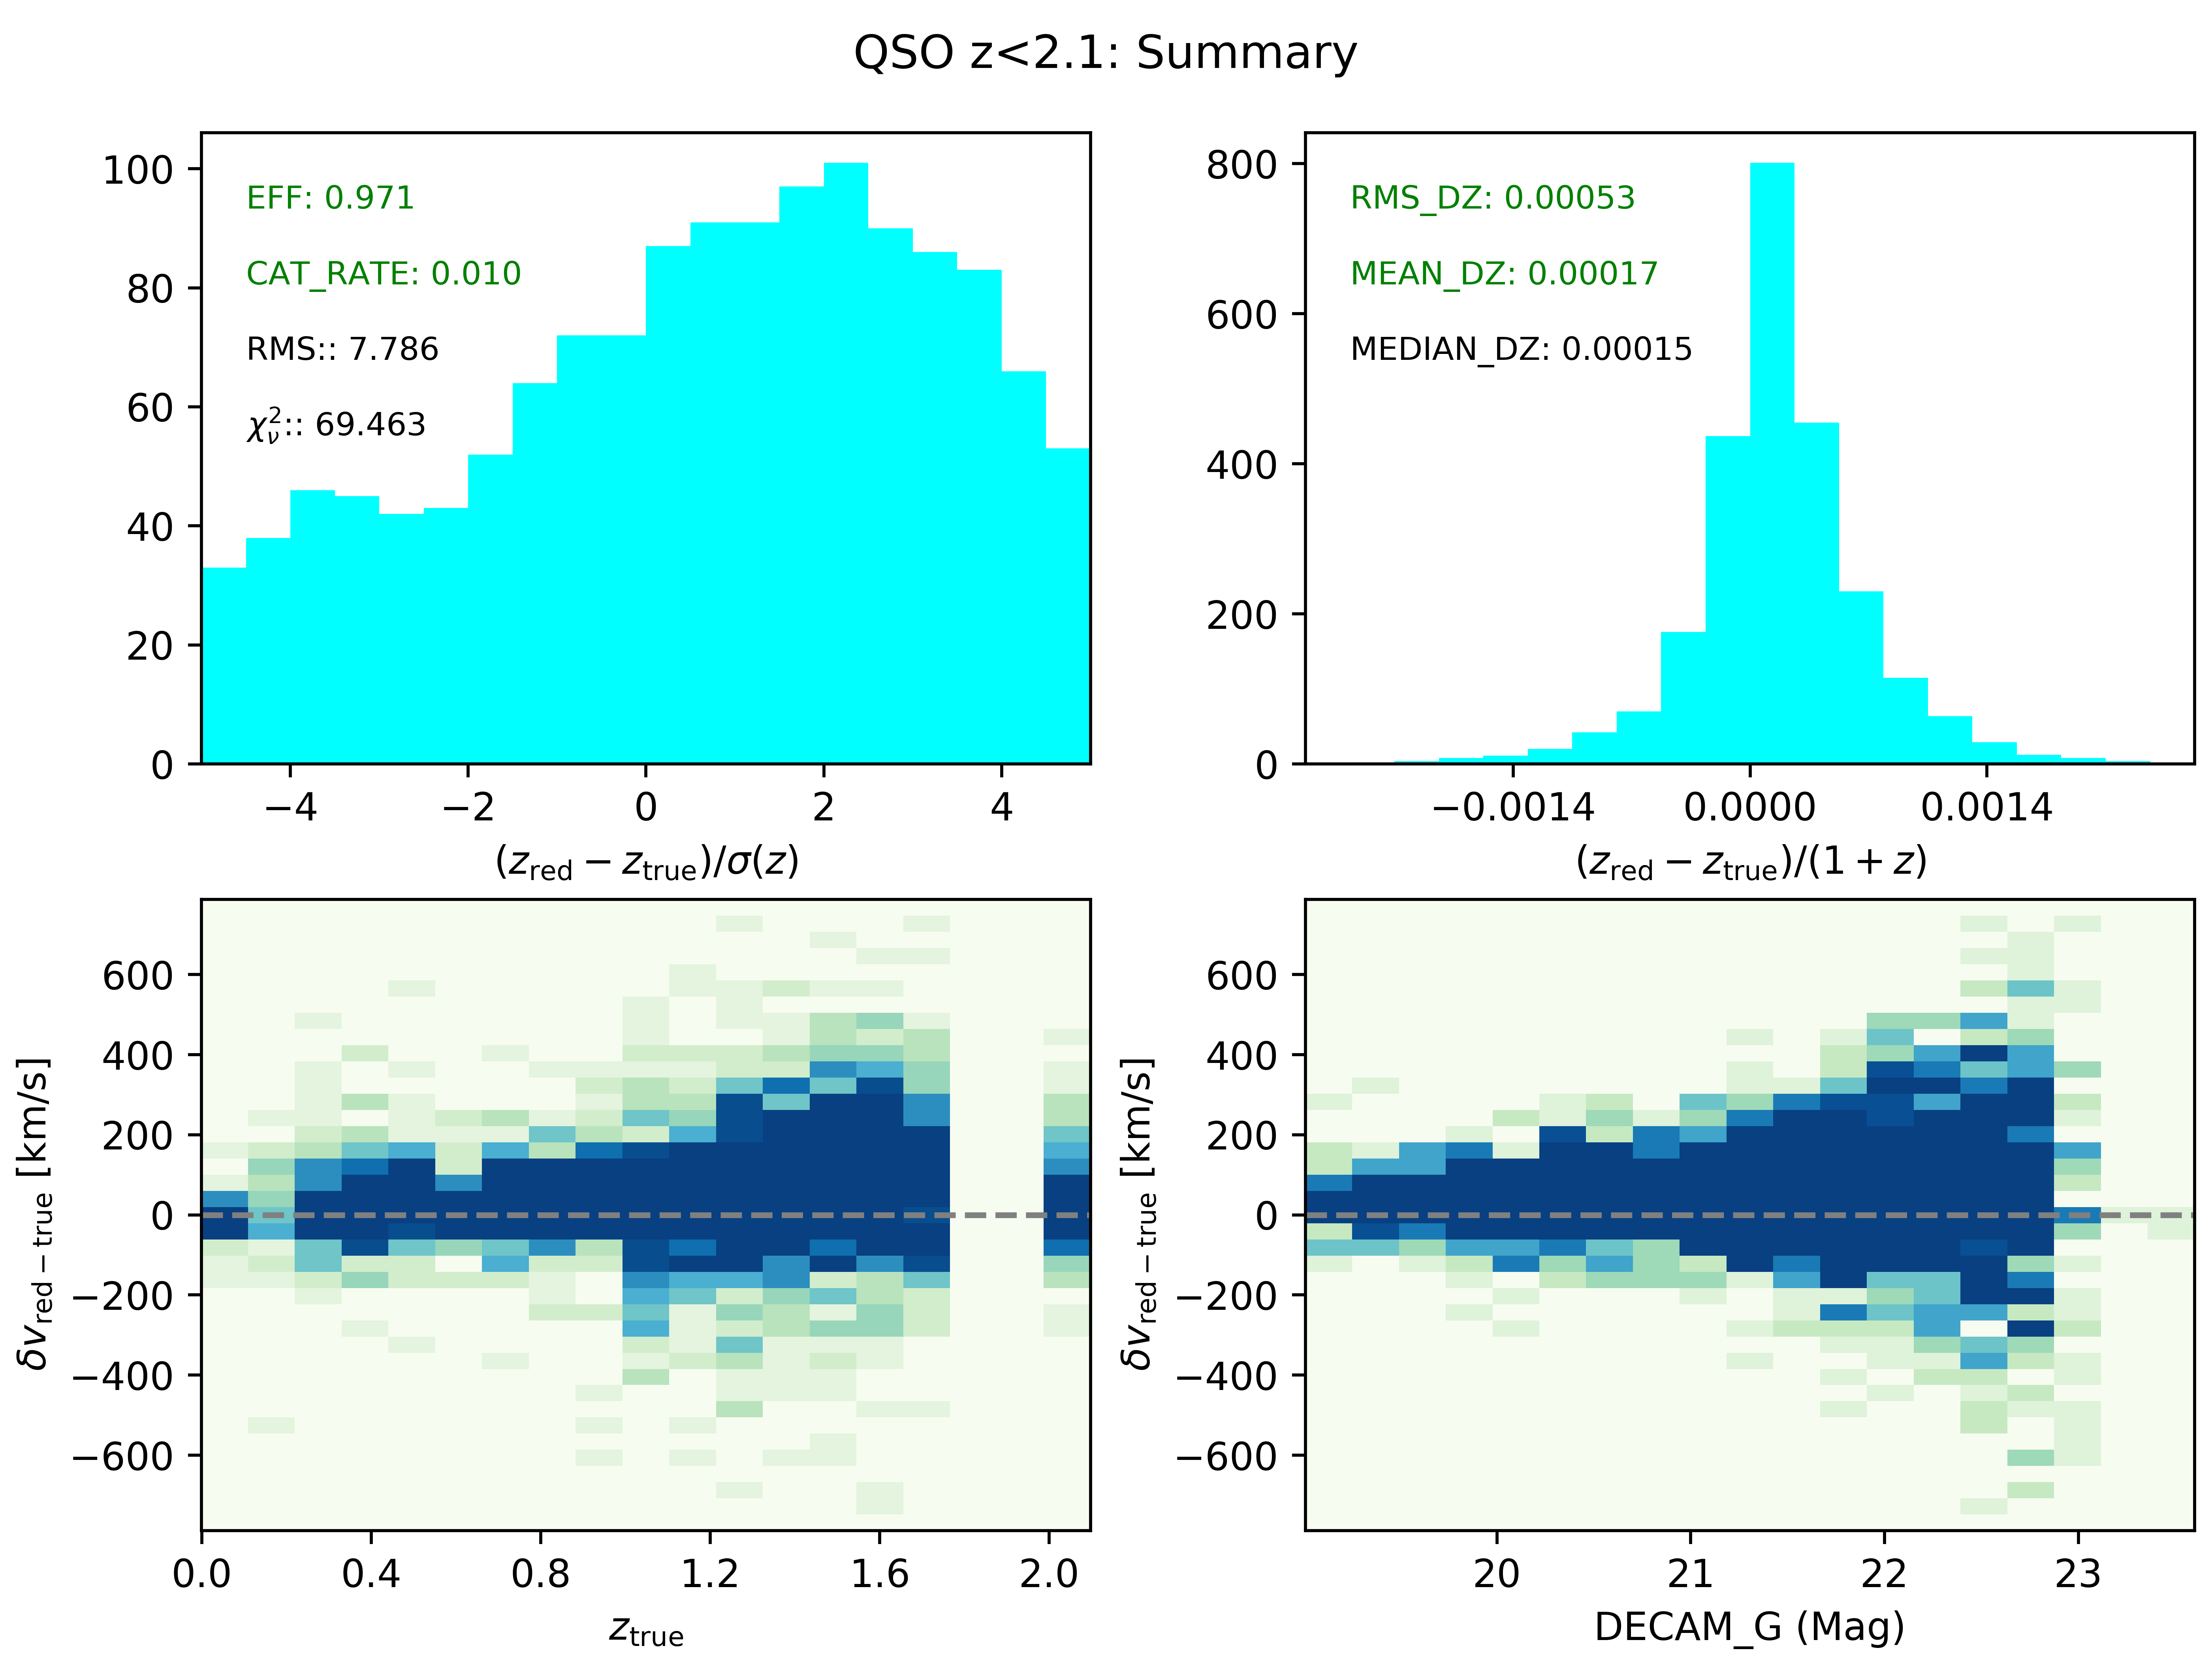

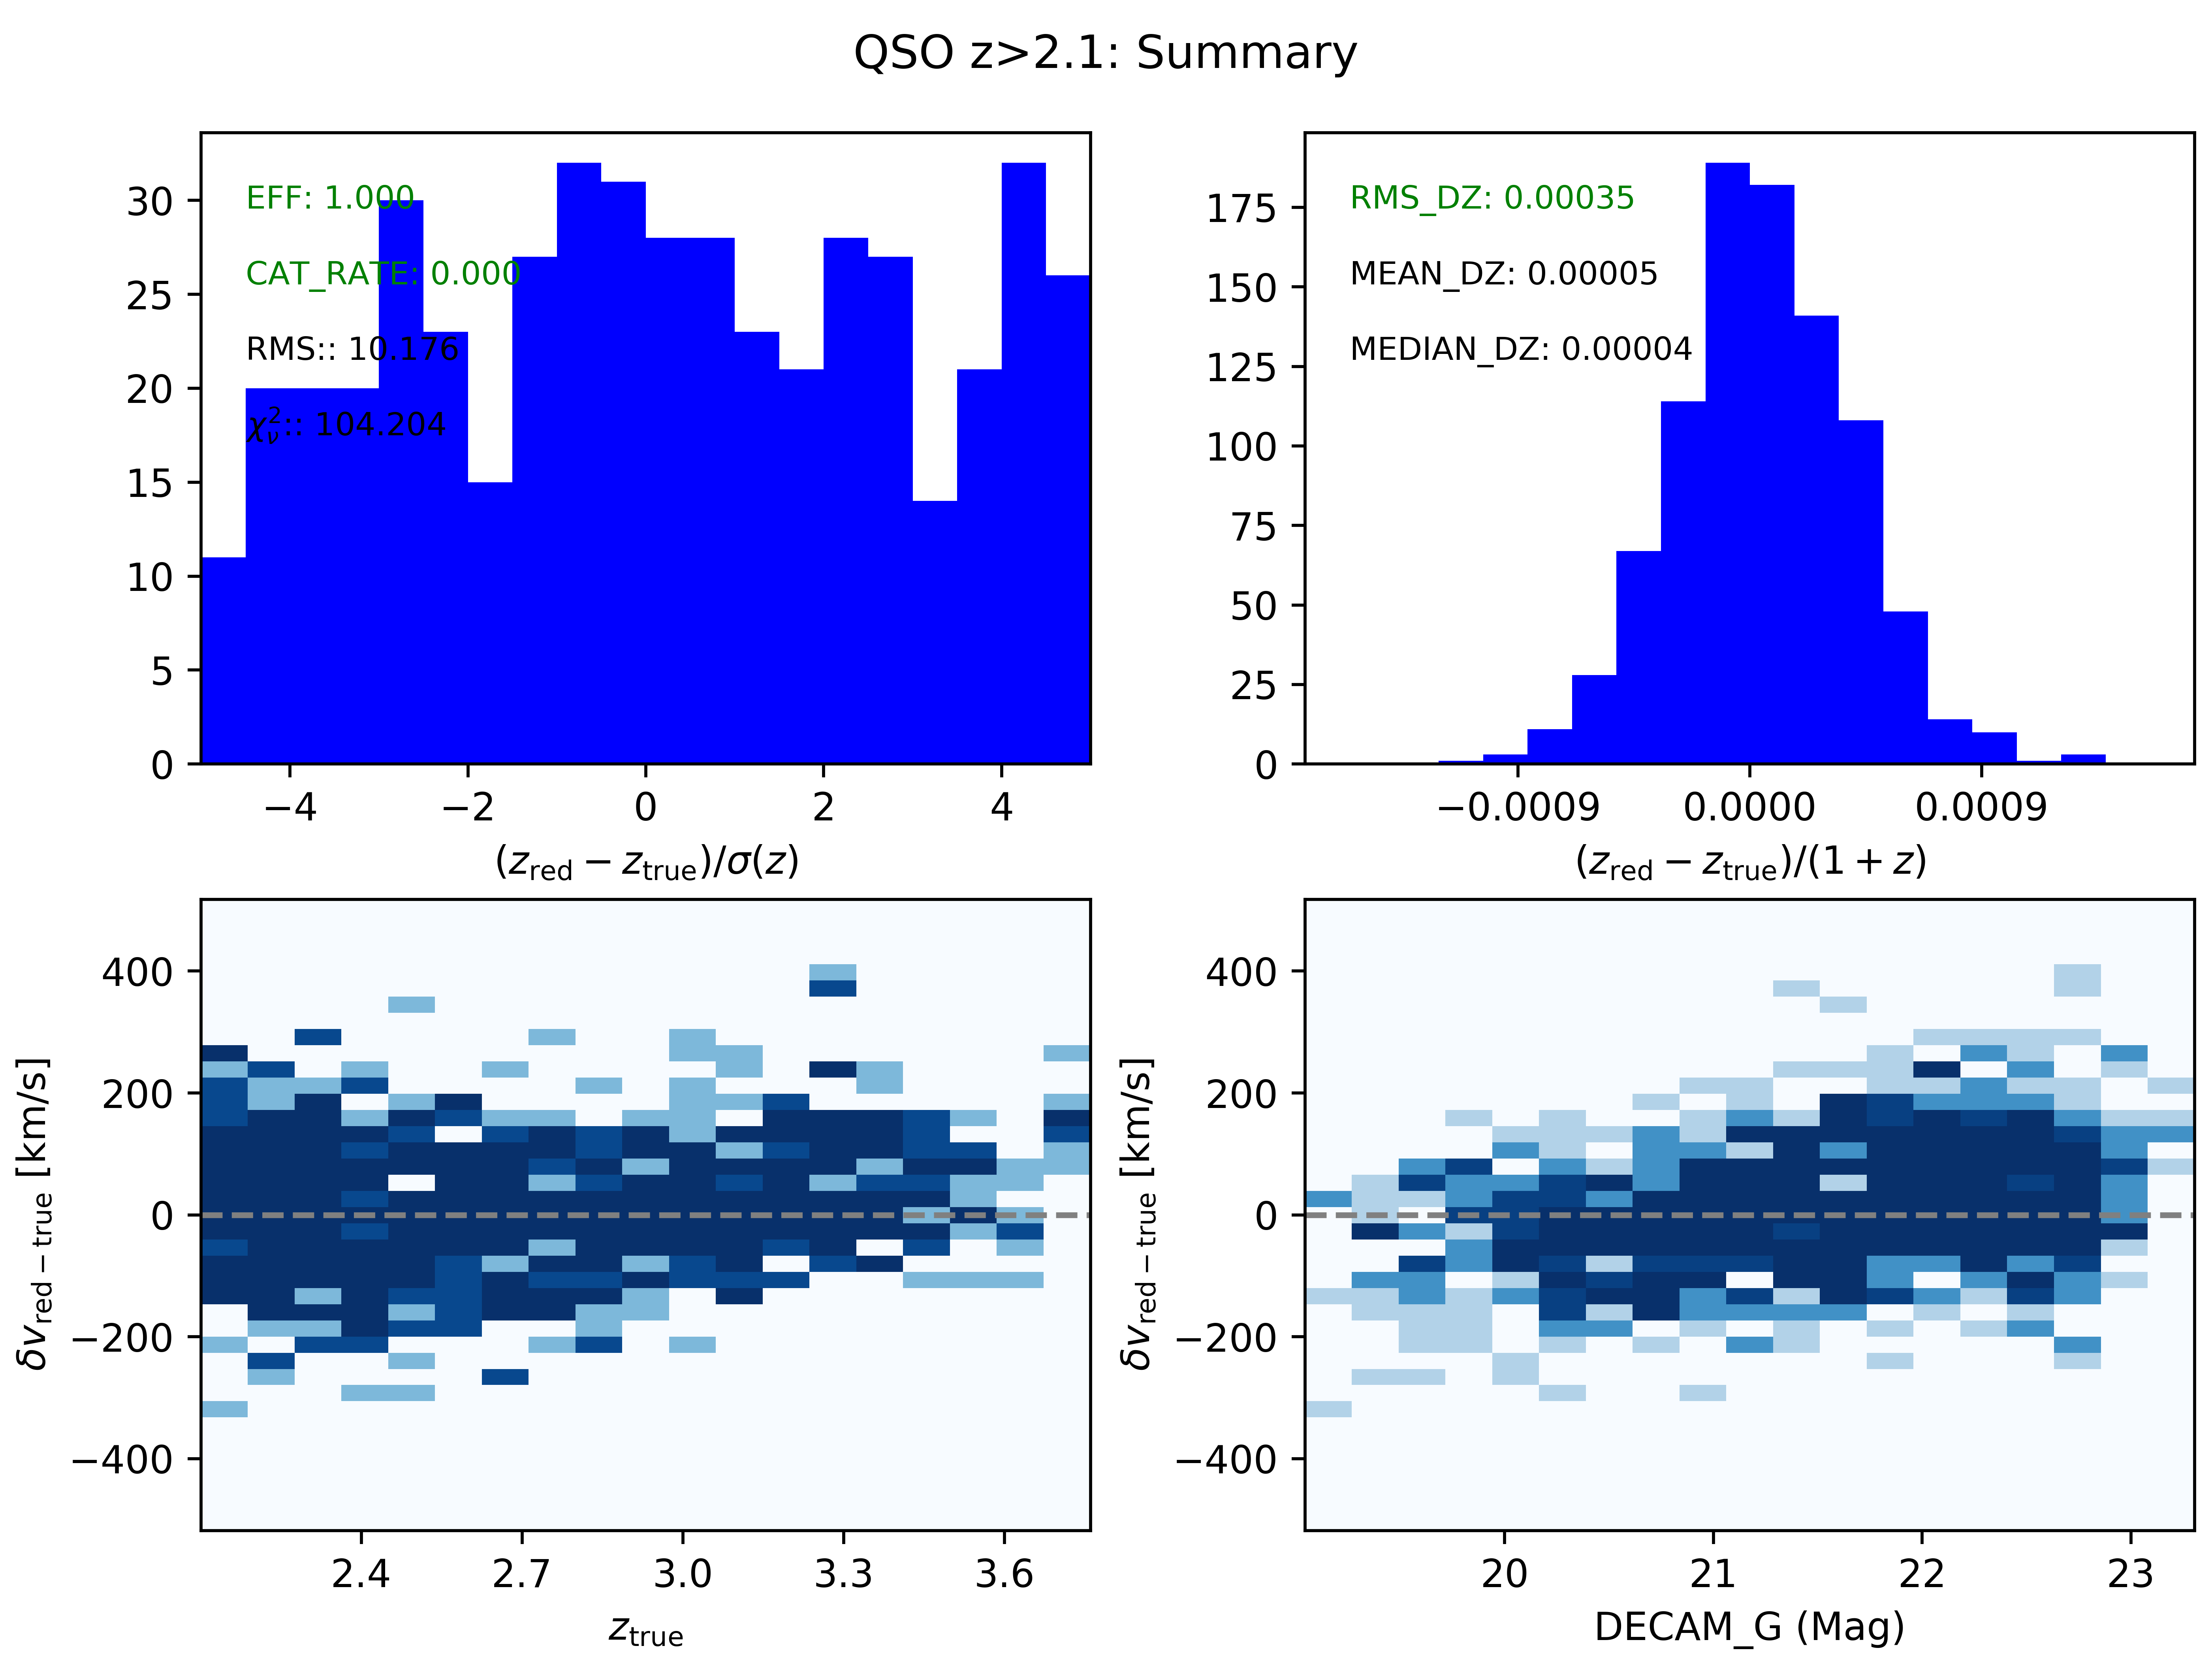

In [148]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_QSO_T.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_QSO_L.png', width=500),
)

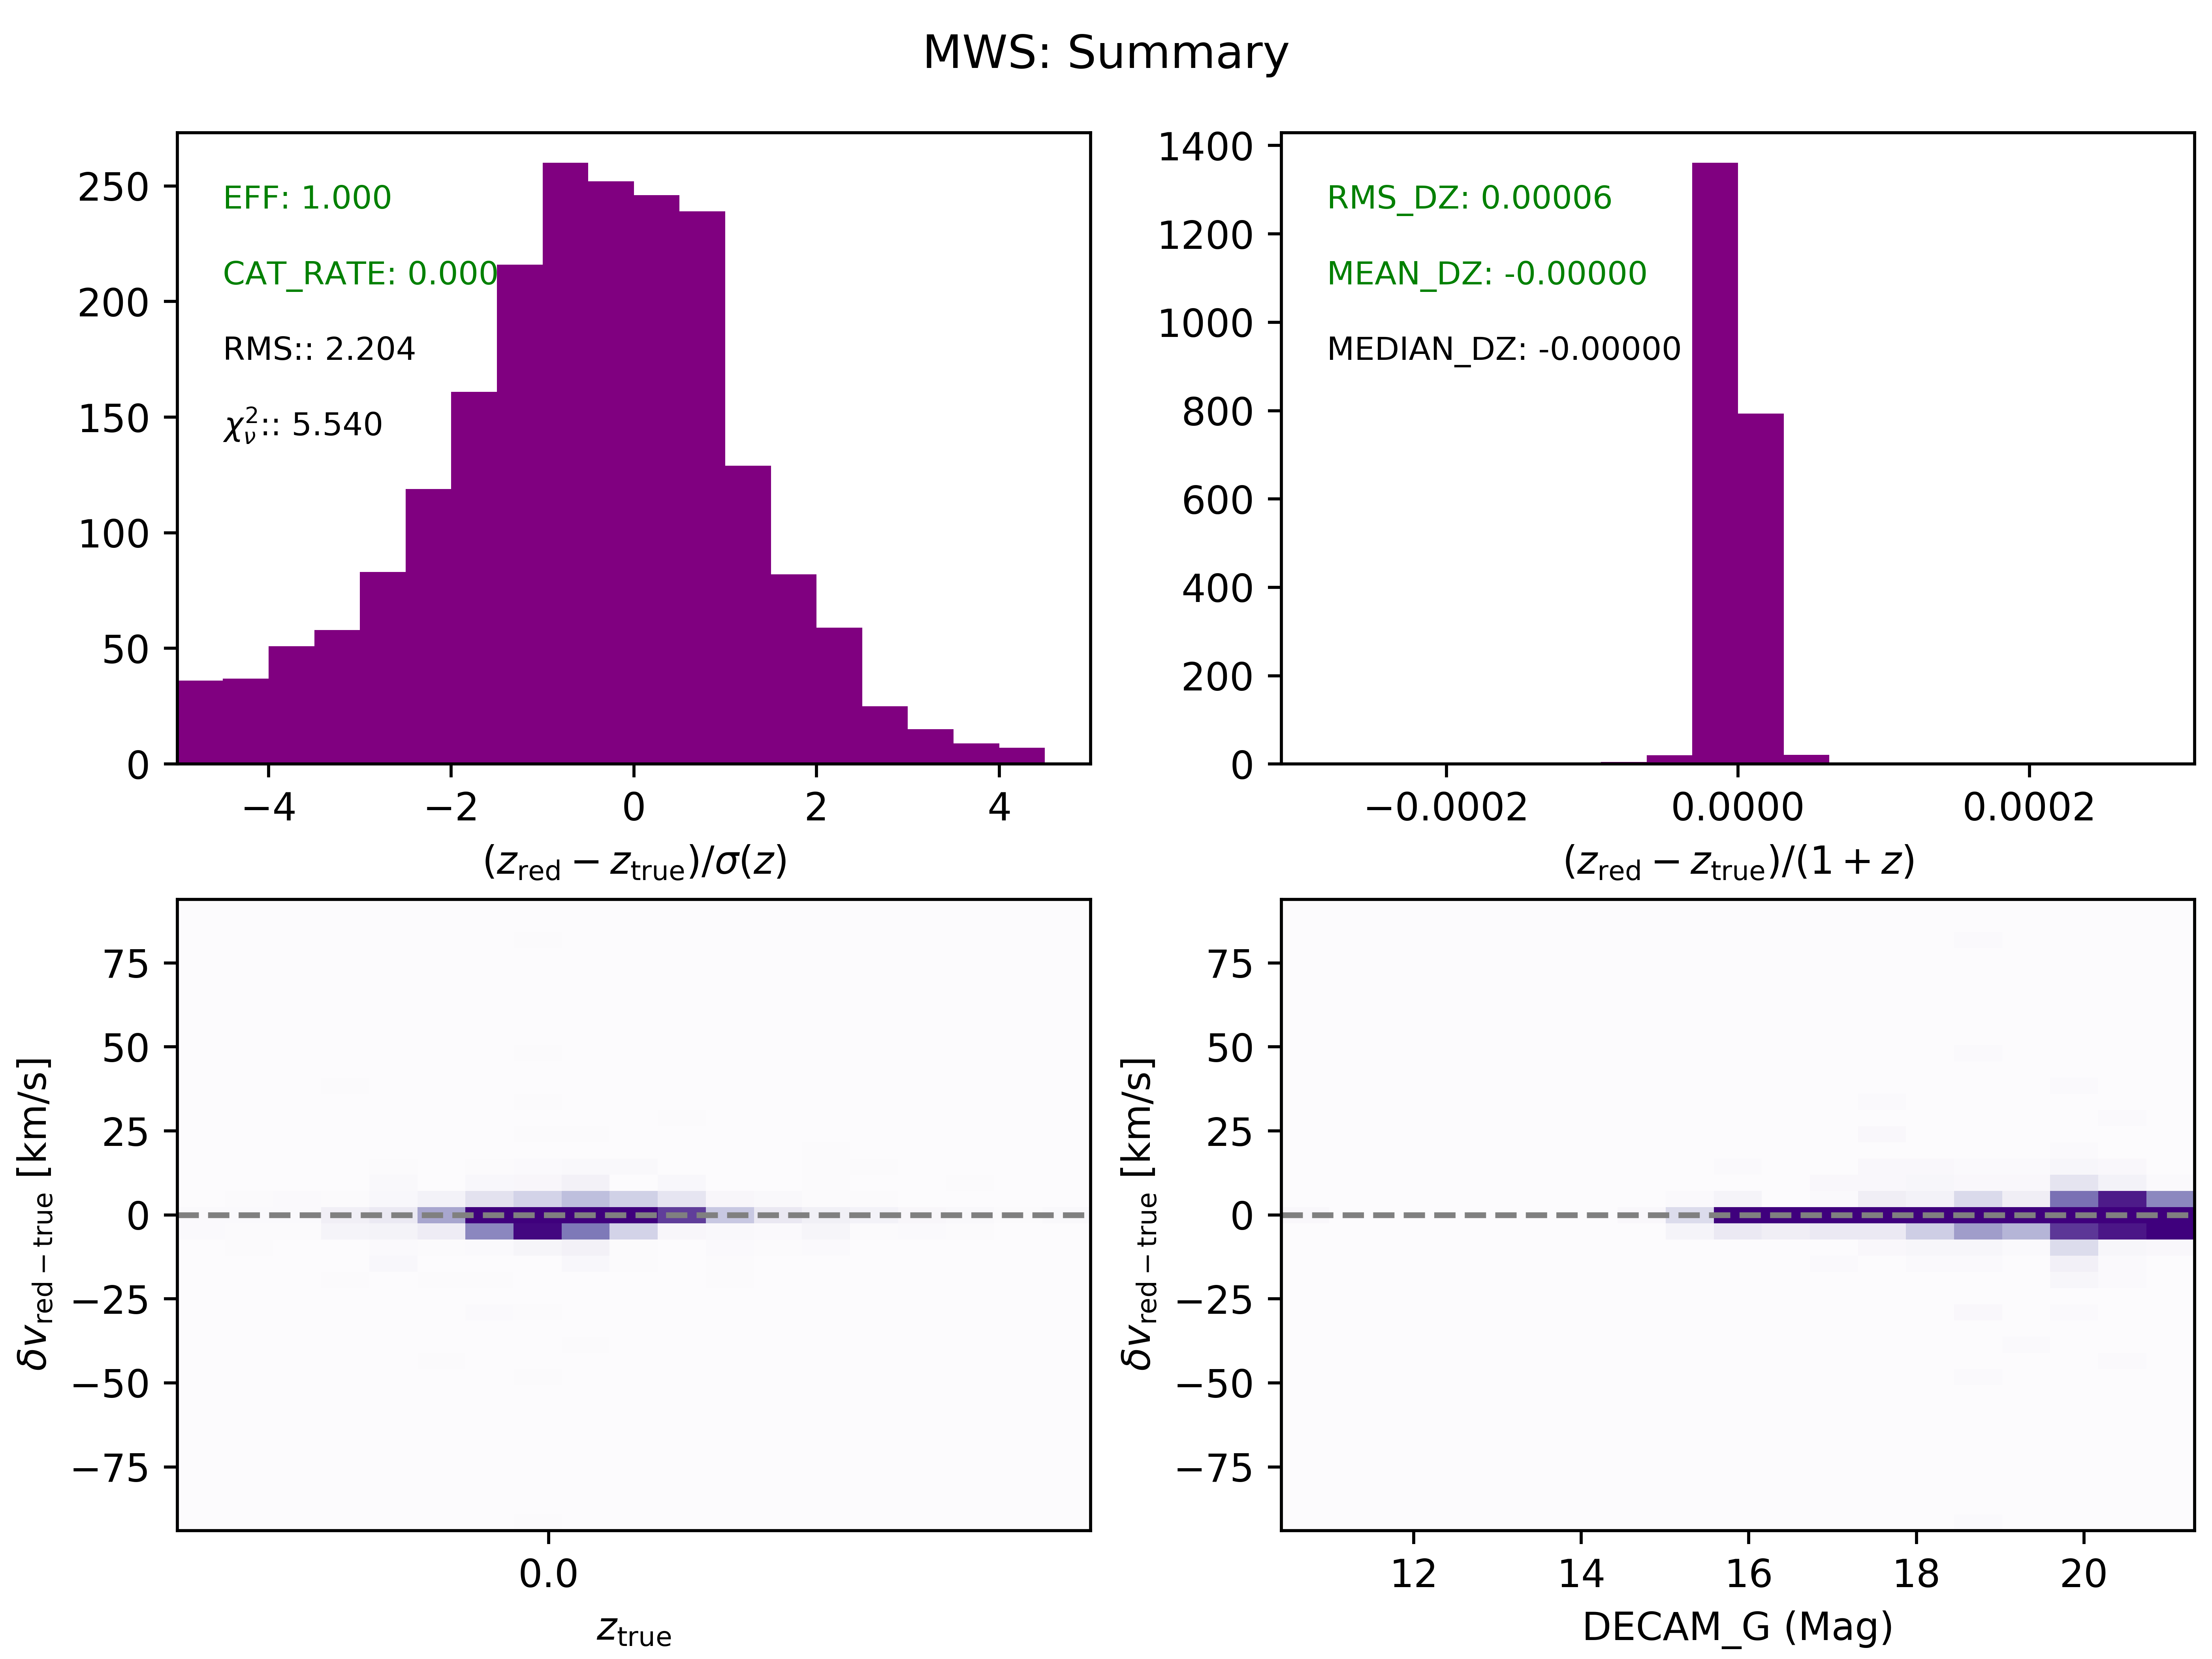

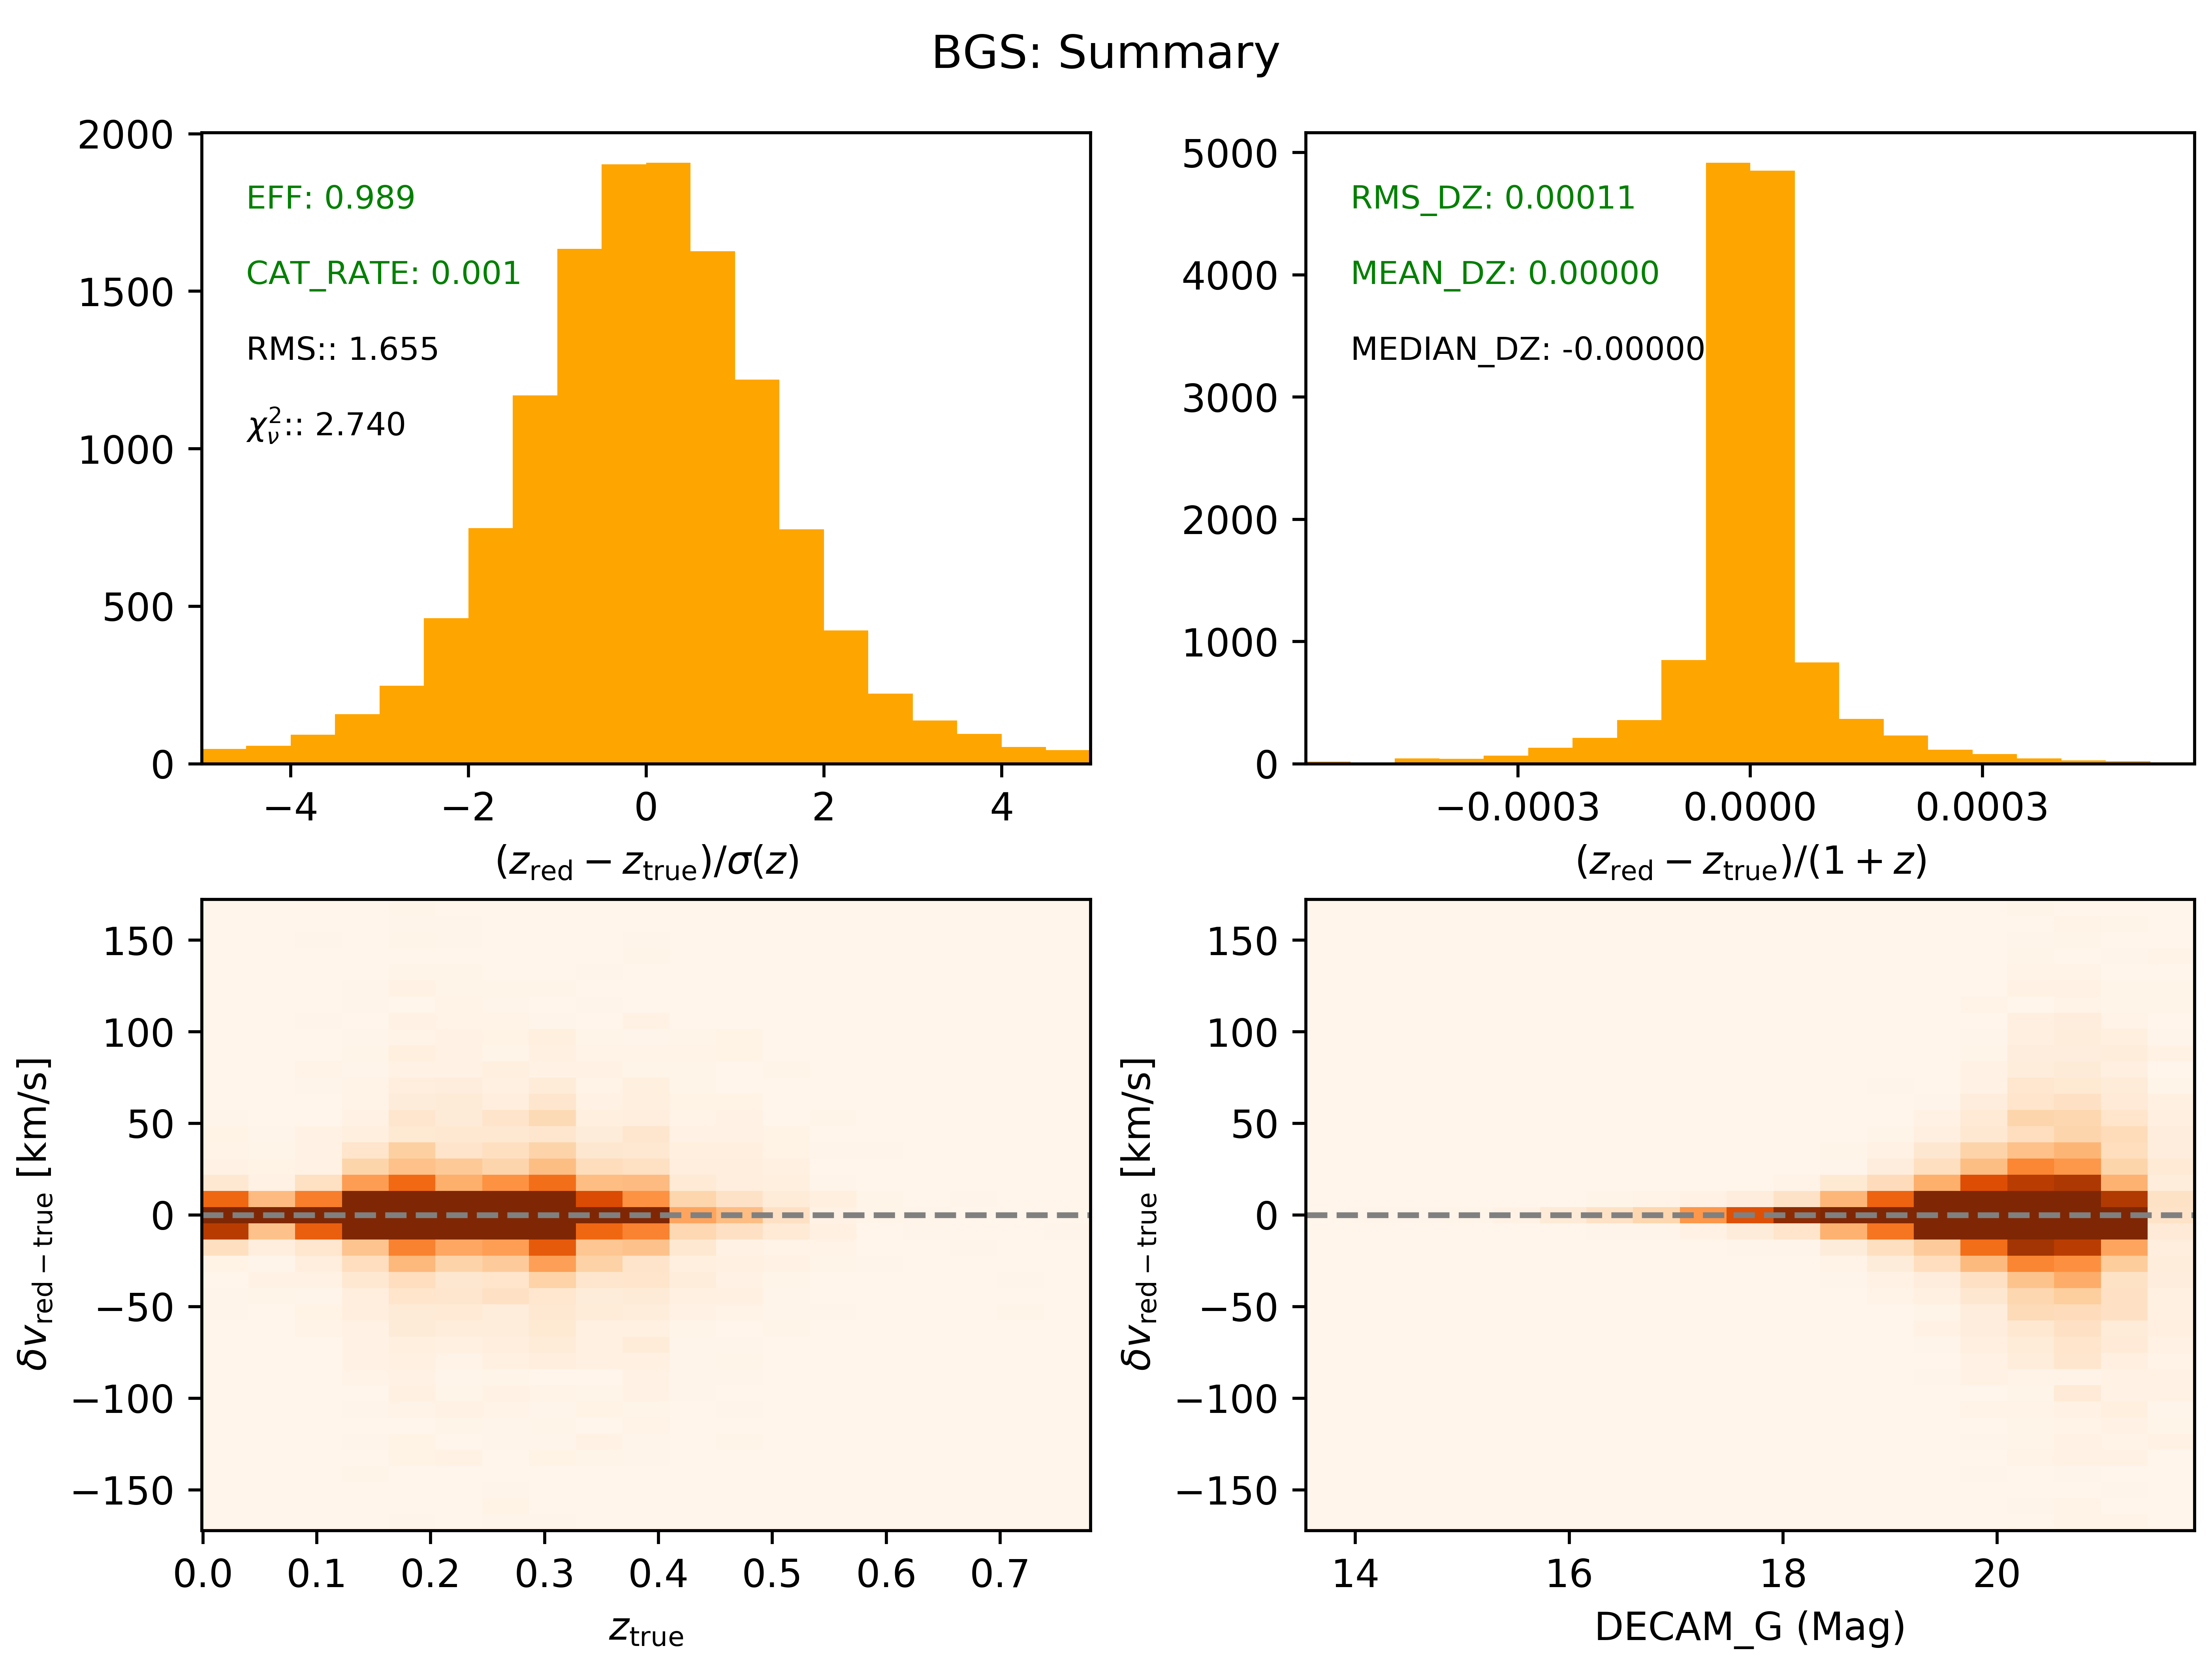

In [149]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_MWS.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_BGS.png', width=500),
)

## Offline QA

In [150]:
qant_logname = os.path.join(qaprod_dir, 'qa_notruth.log')

In [151]:
# Generate the QA (if it doesn't exist already)
qa_start_time = time.time()
with open(qant_logname, 'w') as logfile:
    
    if os.path.exists(qaprod_dir+'/'+os.environ['SPECPROD']+'_qa.json'):
        print("Skipping generating full prod QA file")
    else:
        # Generate yaml files and figures (~30min)
        cmd = "desi_qa_prod --make_frameqa=3 --clobber --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))

        # Slurp (fast)
        cmd = "desi_qa_prod --slurp --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))
    
    # Skyresid (~8min for the two)
    if len(glob.glob(qaprod_dir+'/skyresid_prod_dual*')) == 3:
        print("Skipping generating SkyResid figures")
    else:
        cmd = "desi_qa_skyresid --prod --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))

    if len(glob.glob(qaprod_dir+'/skyresid_prod_gauss*')) == 3:
        print("Skipping generating SkyResid Gaussianity figures")
    else:    
        cmd = "desi_qa_skyresid --gauss --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))
    
    # HTML
    cmd = "desi_qa_prod --html --qaprod_dir={:s}".format(qaprod_dir)
    print('{} RUNNING {}'.format(time.asctime(), cmd))
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    if err:
        raise RuntimeError('see {}'.format(qant_logname))

    
# Time me
print("Done with QA without truth at {}".format(time.asctime()))
qa1_time = time.time() - qa_start_time
print("That took {:.1f} minutes".format(qa1_time/60))

Thu May 10 13:26:05 2018 RUNNING desi_qa_prod --make_frameqa=3 --clobber --qaprod_dir=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA
Thu May 10 14:03:50 2018 RUNNING desi_qa_prod --slurp --qaprod_dir=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA
Thu May 10 14:04:23 2018 RUNNING desi_qa_skyresid --prod --qaprod_dir=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA
Thu May 10 14:09:31 2018 RUNNING desi_qa_skyresid --gauss --qaprod_dir=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA
Thu May 10 14:12:38 2018 RUNNING desi_qa_prod --html --qaprod_dir=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA
Done with QA without truth at Thu May 10 14:12:39 2018
That took 46.6 minutes


### Check

In [152]:
# JSON file
prod_qa = desispec.io.qa.load_qa_multiexp(qaprod_dir+'/'+os.environ['SPECPROD']+'_qa')
assert isinstance(prod_qa, dict)
assert len(prod_qa.keys()) == 4
# PNGs
assert len(glob.glob(qaprod_dir+'/skyresid_prod_dual*')) == 3
assert len(glob.glob(qaprod_dir+'/skyresid_prod_gauss*')) == 3
# HTML
assert os.path.exists(qaprod_dir+'/qa-toplevel.html')

INFO:qa.py:220:load_qa_multiexp: Loading QA prod file: /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/QA/mini_qa.json


### Show

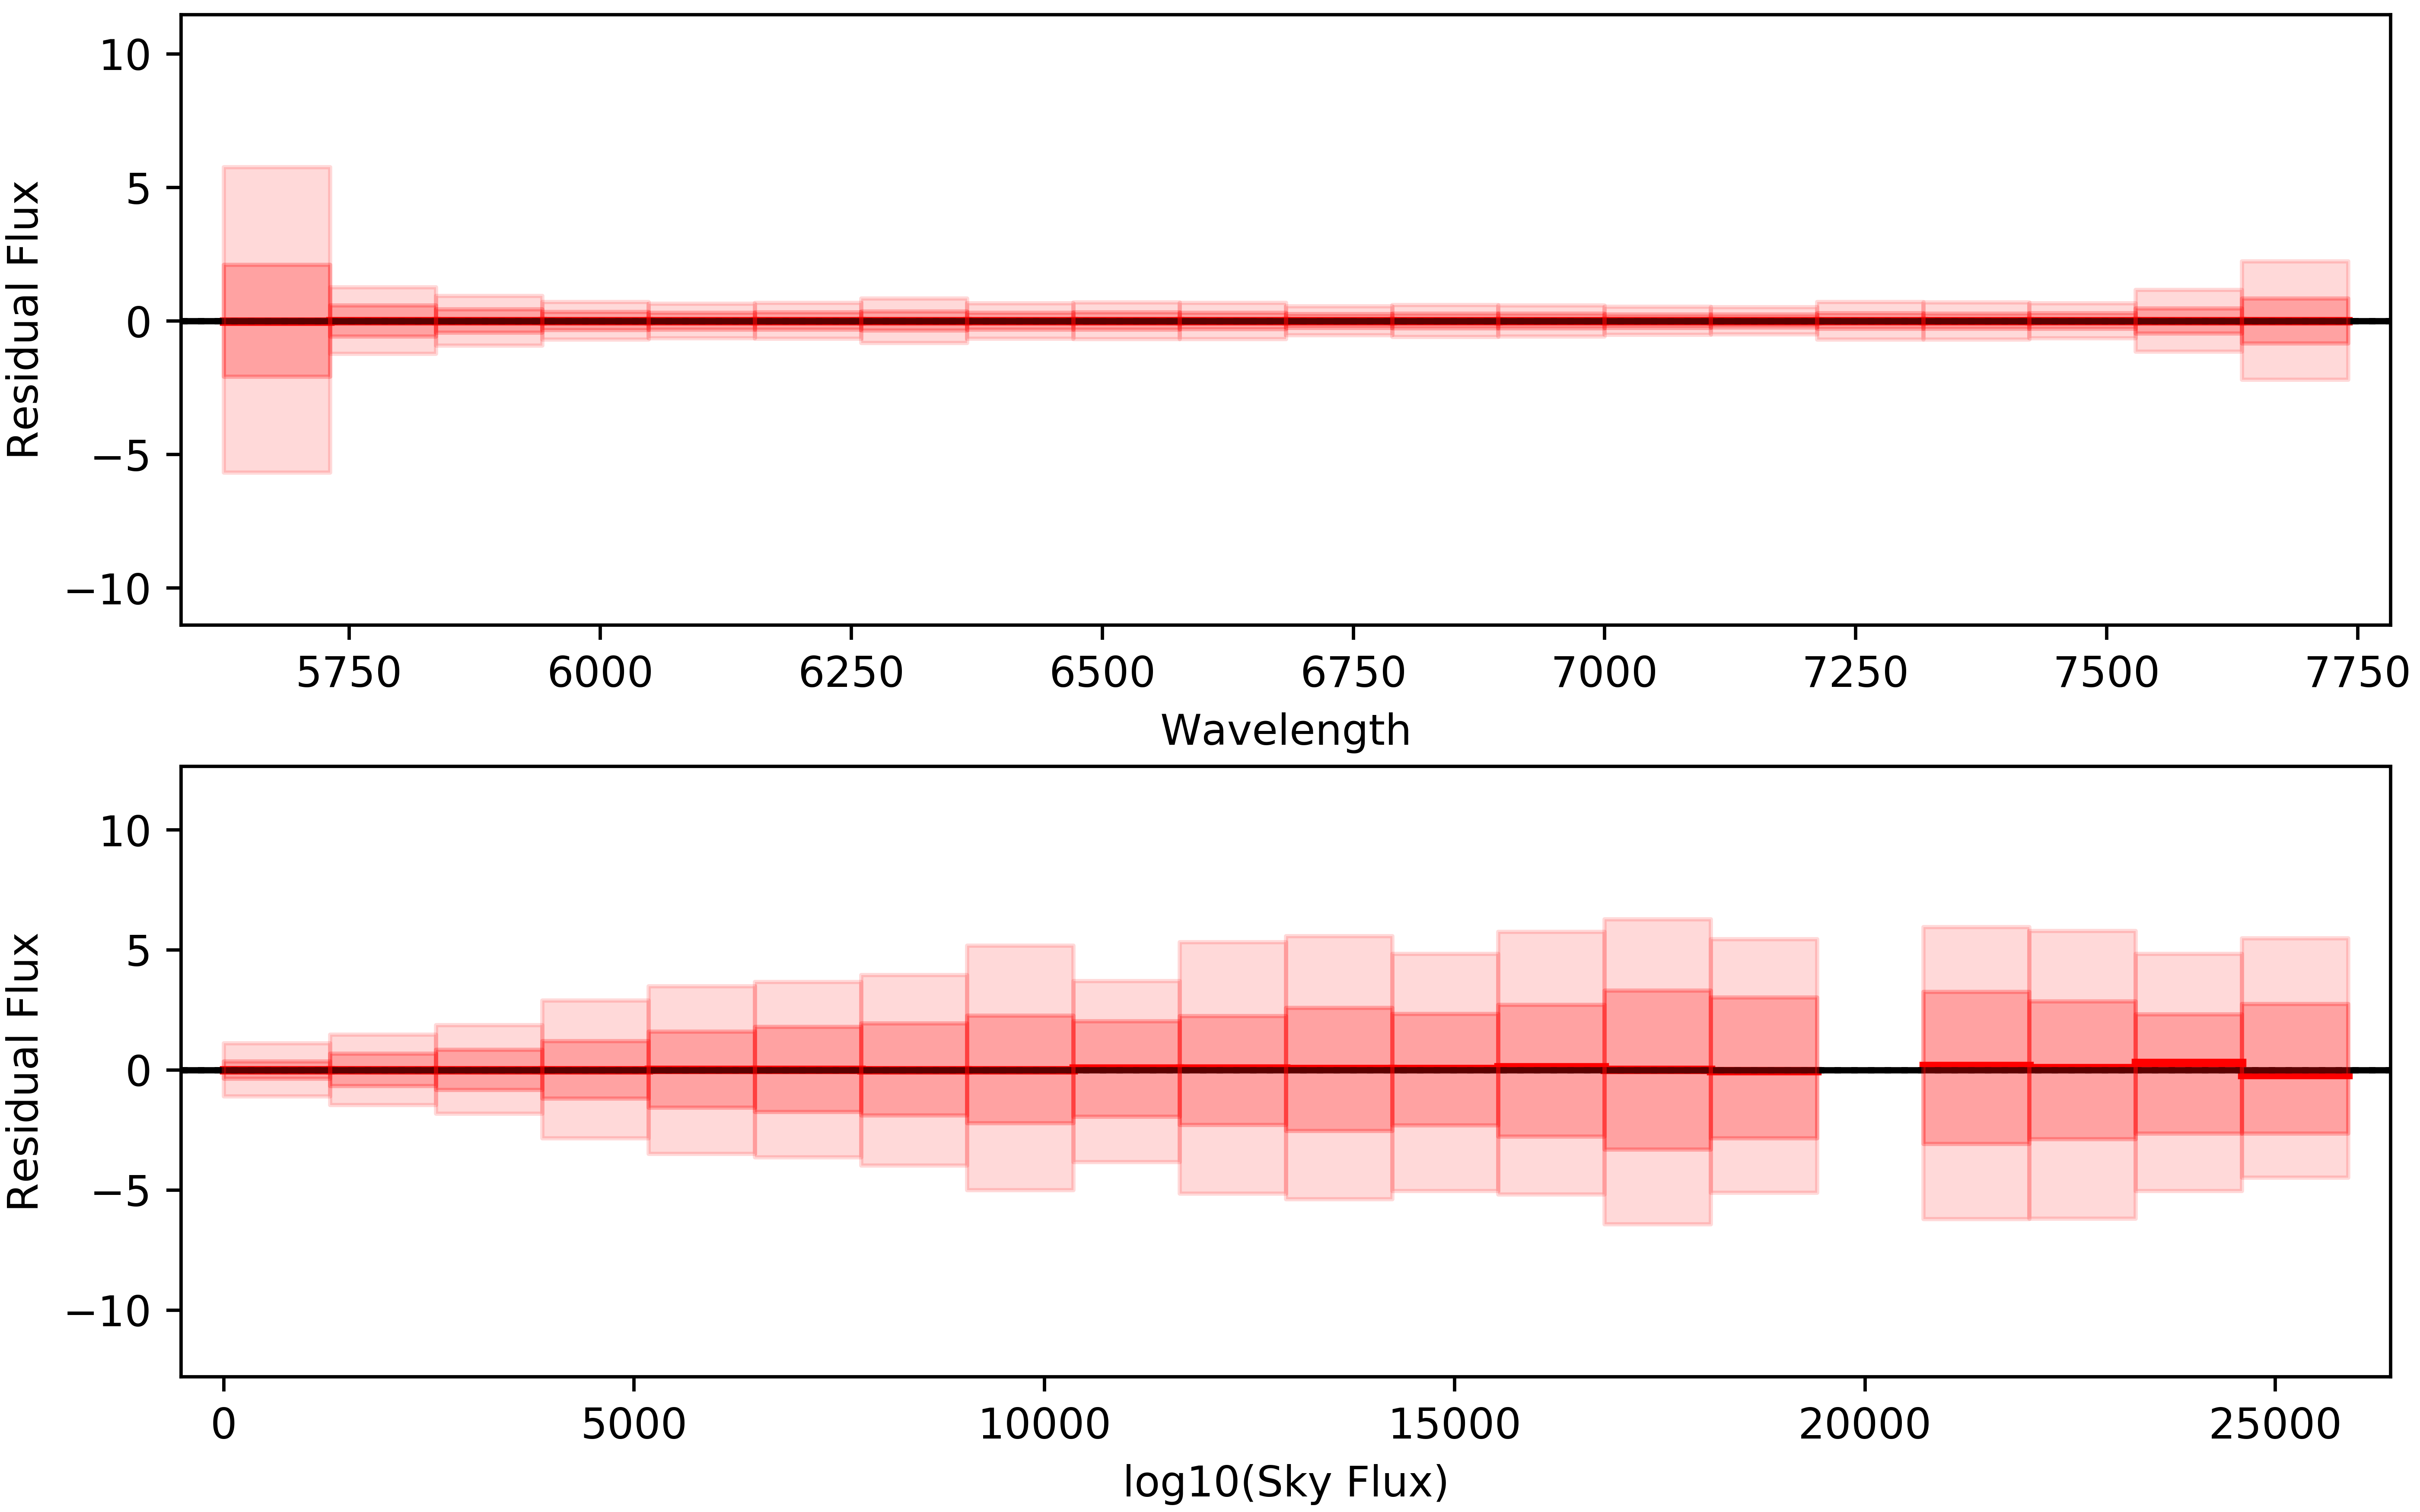

In [153]:
from IPython.display import Image
Image(filename=qaprod_dir+'/skyresid_prod_dual_r.png')

## Finish Up

In [154]:
print("Done at {}".format(time.asctime()))
run_time = time.time() - notebook_start_time
print("That took {:.1f} minutes".format(run_time/60))

Done at Thu May 10 14:12:39 2018
That took 159.1 minutes


# TODO

A wishlist of things to add to this notebook
* Target selection QA